In [662]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [354]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

from src.parameters import ANIMALS, SAMPLING_FREQUENCY

In [355]:
epoch_key = ('HPa', 2, 4)

In [356]:
from loren_frank_data_processing import (get_interpolated_position_dataframe,
                                         get_LFP_dataframe,
                                         get_spike_indicator_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe, save_xarray)
from spectral_connectivity import Connectivity, Multitaper
from src.analysis import (_center_time, adjusted_coherence_magnitude,
                          connectivity_by_ripple_type,
                          decode_ripple_clusterless, detect_epoch_ripples,
                          get_hippocampal_theta, get_ripple_indicator,
                          get_ripple_locked_spikes,
                          ripple_triggered_connectivity)


position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, SAMPLING_FREQUENCY, position_info)
ripple_indicator = get_ripple_indicator(
    epoch_key, ANIMALS, ripple_times)
neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')


INFO:src.analysis:Detecting ripples


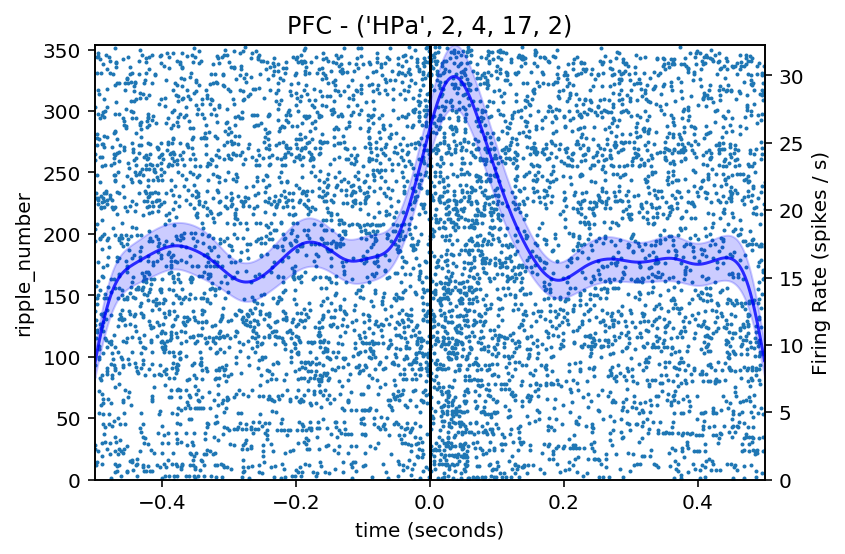

In [5]:
from src.visualization import plot_perievent_raster

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)

plot_perievent_raster(('HPa', 2, 4, 17, 2), ANIMALS, ripple_times, tetrode_info, s=1);

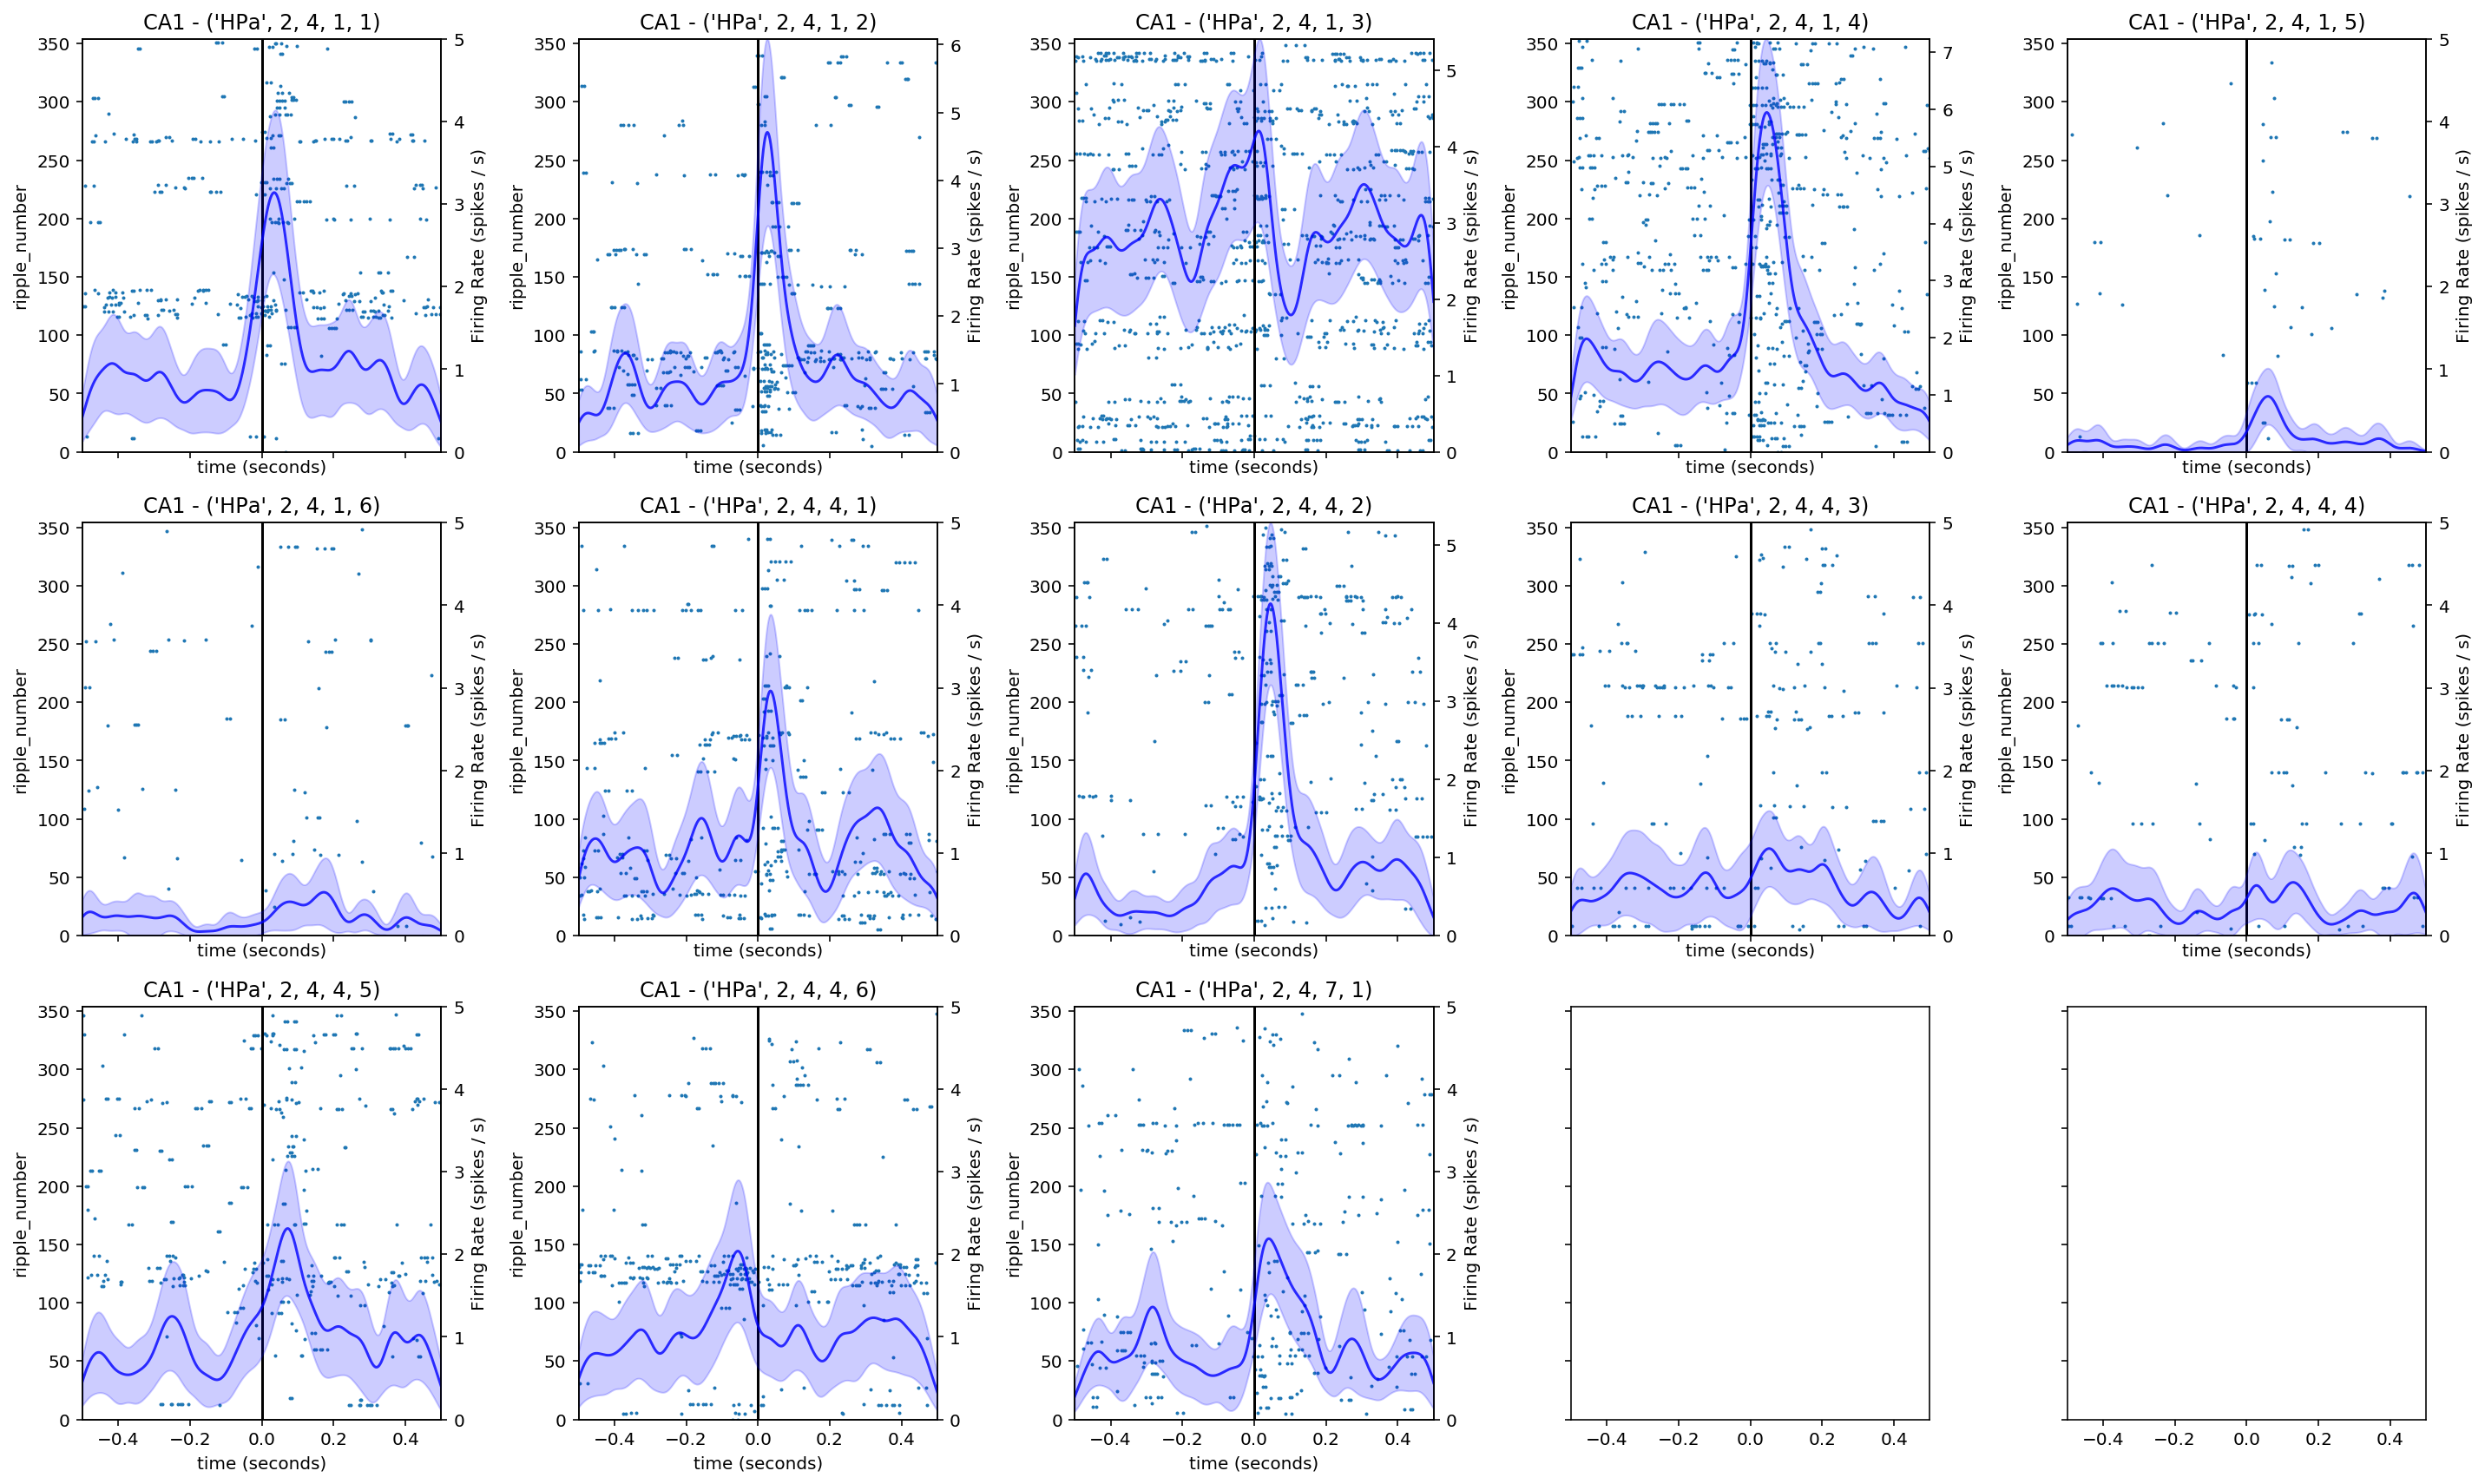

In [6]:
ca1_keys = neuron_info.loc[(neuron_info.area == 'CA1') & (neuron_info.numspikes > 0)].index.tolist()
n_neurons = len(ca1_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 4, n_rows * 4), sharex=True, sharey=True)

for ax, key in zip(axes.ravel(), ca1_keys):
    plot_perievent_raster(key, ANIMALS, ripple_times, tetrode_info, ax=ax, s=1);
    
plt.tight_layout()

In [6]:
from loren_frank_data_processing import reshape_to_segments, get_spike_indicator_dataframe

def get_trial_spikes(neuron_key, animals, events,
                     window_offset=(-0.5, 0.5),
                     sampling_frequency=1500):
    spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
    return reshape_to_segments(
        spikes, events, window_offset=window_offset,
        sampling_frequency=sampling_frequency).unstack(level=0).fillna(0)
    
def jspth(spikes1, spikes2):
    '''Joint Peristimulus Time Histogram
    
    Parameters
    ----------
    spikes1, spikes2: ndarray, shape (n_time, n_trials)
    
    Returns
    -------
    joint_histogram : ndarray, shape (n_time, n_time)
    
    '''
    n_time = spikes1.shape[0]
    joint_histogram = np.zeros((n_time, n_time))
    for single_trial_spikes1, single_trial_spikes2 in zip(spikes1.T, spikes2.T):
        joint_histogram += (single_trial_spikes1[:, np.newaxis]
                            * single_trial_spikes2[:, np.newaxis].T)
    
    return joint_histogram

def plot_jspth(neuron_key1, neuron_key2, animals, events, window_offset=(-0.5, 0.5),
                     sampling_frequency=1500, ax=None, **plot_kwargs):
    spikes1 = get_trial_spikes(neuron_key1, animals, events,
                               window_offset, sampling_frequency).resample('25ms')
    spikes2 = get_trial_spikes(neuron_key2, animals, events,
                               window_offset, sampling_frequency).resample('25ms')
    if ax is None:
        ax = plt.gca()
    
    time = spikes1.index.get_level_values('time').total_seconds()
    x, y = np.meshgrid(time, time)
    data = jspth(spikes1.values, spikes2.values)
    mappable = ax.pcolormesh(x, y, data.T, vmax=data.max(), **plot_kwargs)
    return mappable

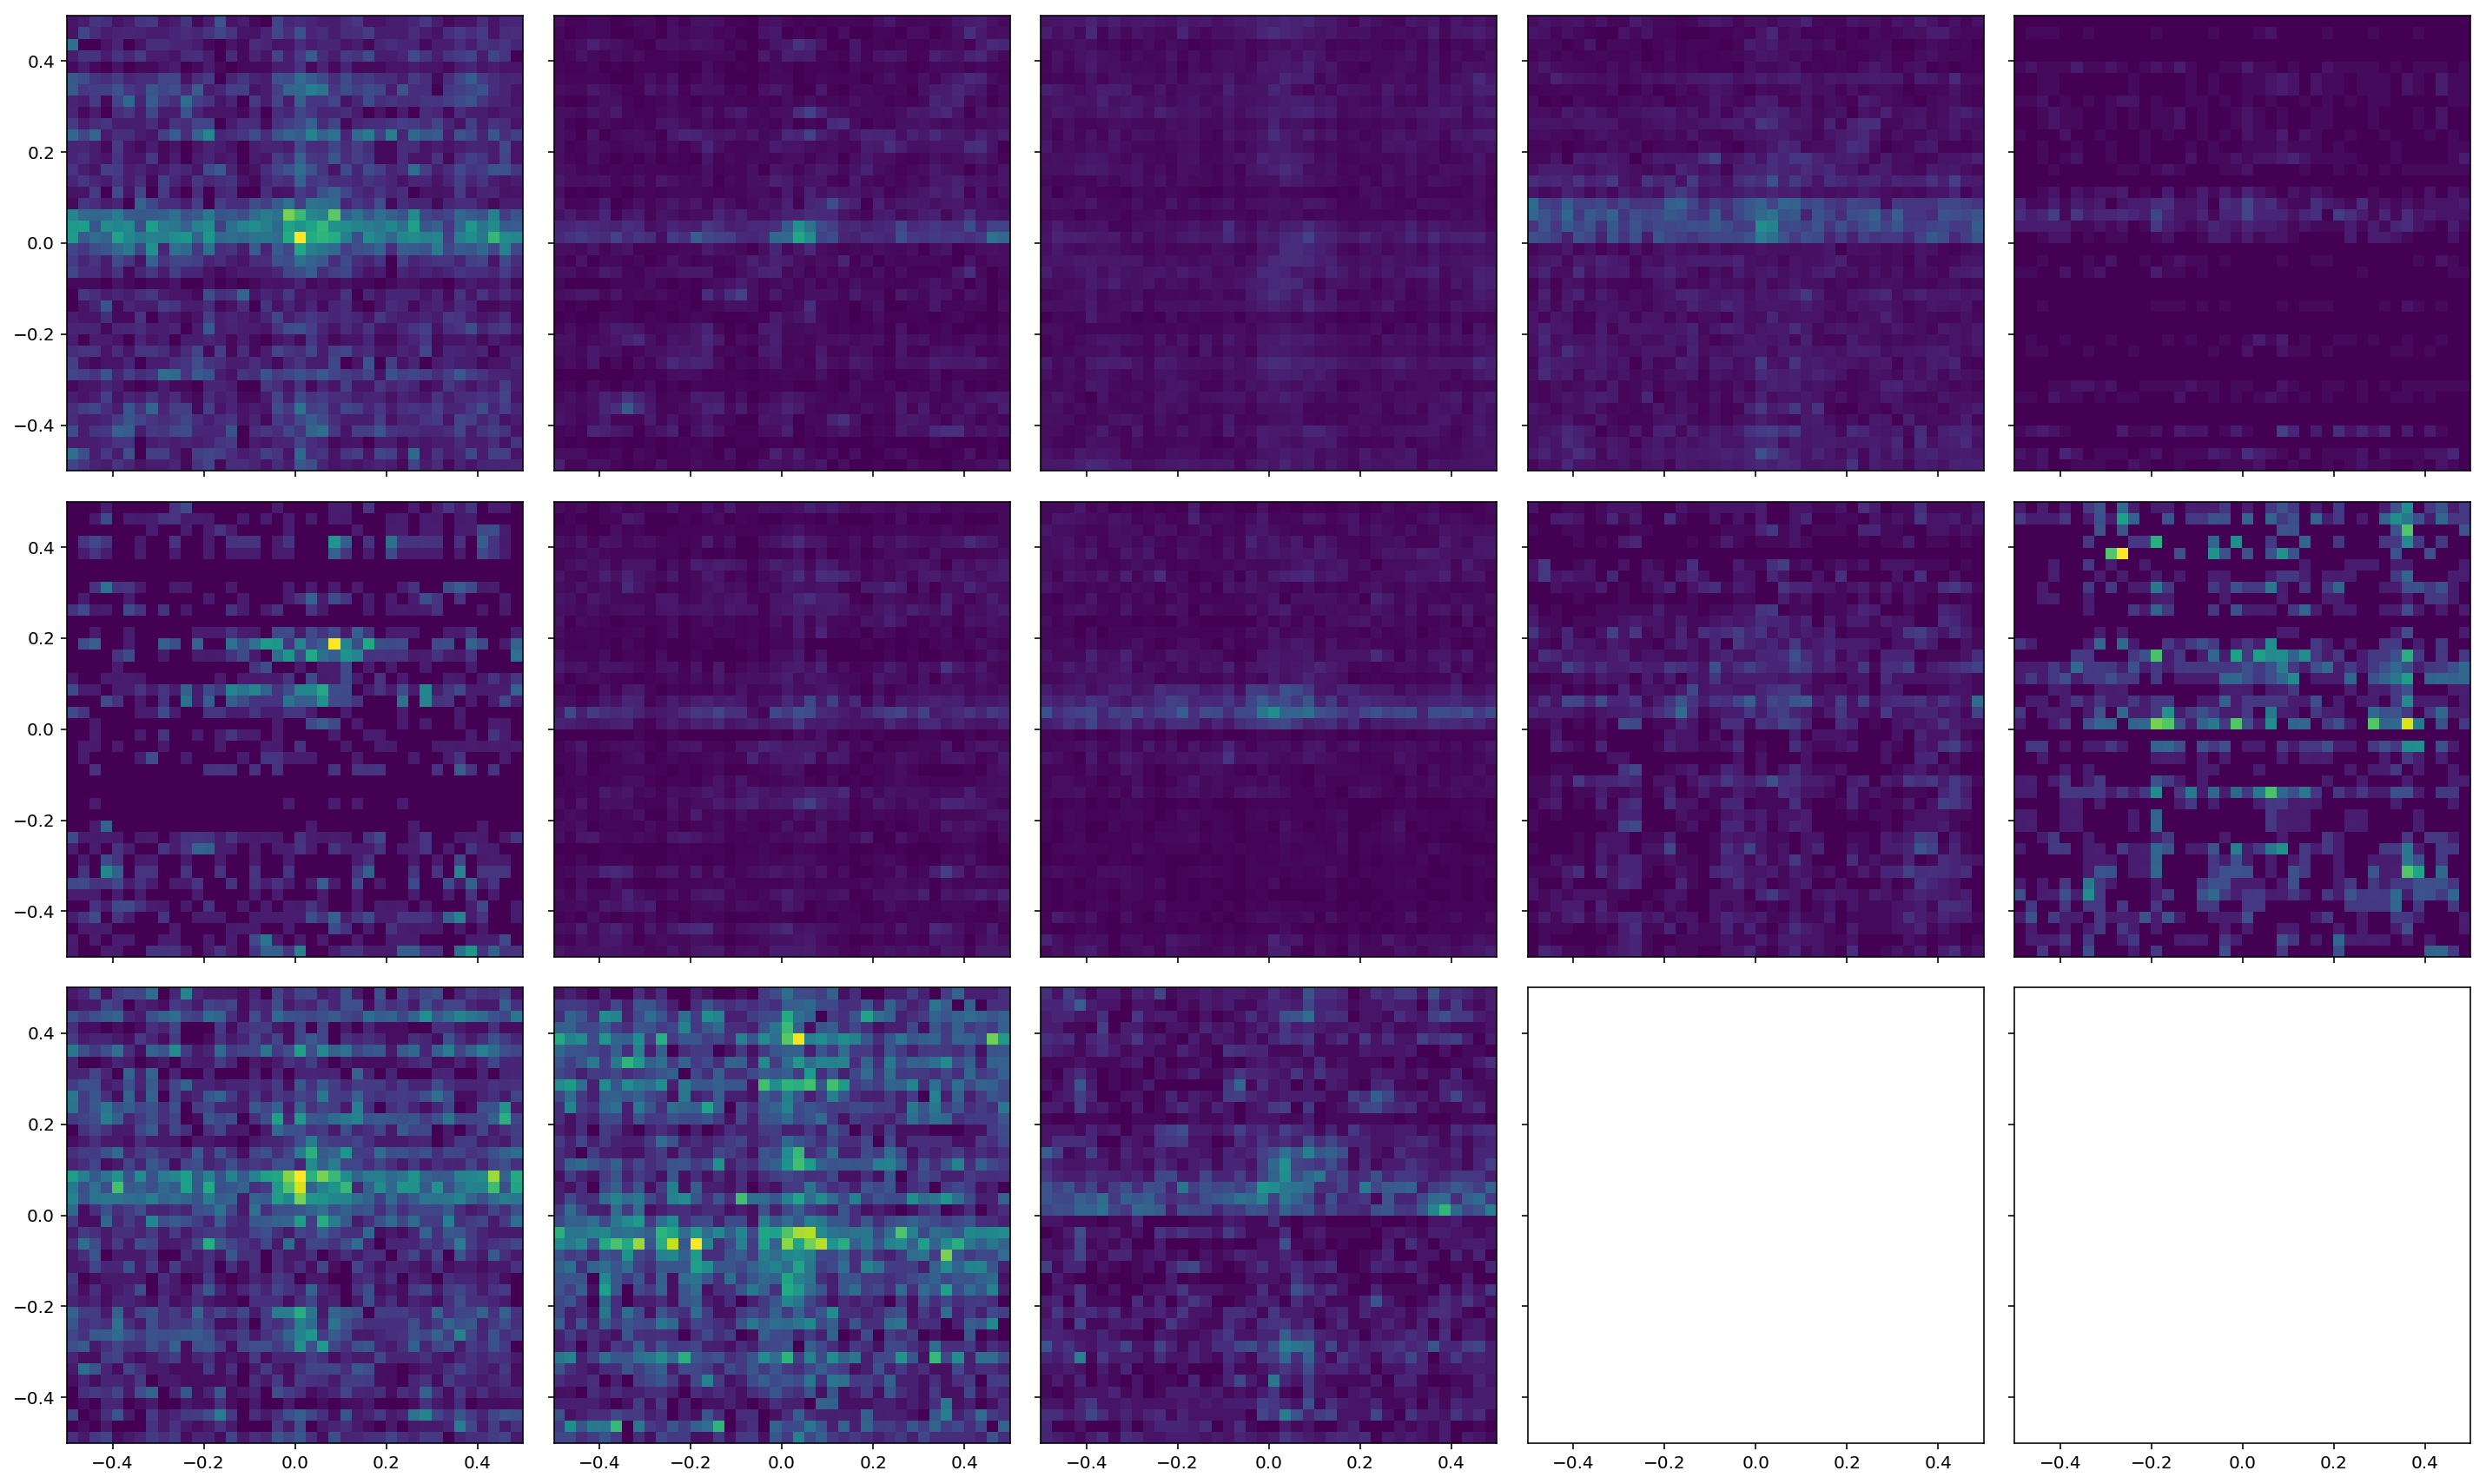

In [8]:
ca1_keys = neuron_info.loc[(neuron_info.area == 'CA1') & (neuron_info.numspikes > 0)].index.tolist()
n_neurons = len(ca1_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 4, n_rows * 4), sharex=True, sharey=True)

for ax, key in zip(axes.ravel(), ca1_keys):
    plot_jspth(('HPa', 2, 4, 17, 2), key, ANIMALS, ripple_times, ax=ax)

plt.tight_layout()

In [11]:
from src.spike_models import fit_glm, lag
from patsy import dmatrix, build_design_matrices
from src.spike_train import simulate_poisson_process

neuron_key = ('HPa', 2, 4, 17, 2)

def fit_constant(neuron_key, animals, sampling_frequency,
                 window_offset=(-0.500, 0.500), penalty=None):
    spikes = get_spike_indicator_dataframe(neuron_key, animals)
    ripple_locked_spikes = reshape_to_segments(
            spikes, ripple_times, window_offset=window_offset,
            sampling_frequency=sampling_frequency)

    time = ripple_locked_spikes.index.get_level_values('time')
    unique_time = np.unique(time.total_seconds().values)
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)


    design_matrix = np.ones_like(ripple_locked_spikes)
    is_spike = ripple_locked_spikes.values.squeeze()
    results = fit_glm(is_spike, design_matrix, penalty)
    simulated_spikes = pd.DataFrame(simulate_poisson_process(
        np.exp(np.dot(design_matrix, results.coefficients)) * sampling_frequency,
        sampling_frequency), index=ripple_locked_spikes.index).unstack(level=0).values
    return results, simulated_spikes


def fit_ripple_time(neuron_key, animals, sampling_frequency,
                    knot_spacing=0.050, window_offset=(-0.500, 0.500), penalty=None):
    spikes = get_spike_indicator_dataframe(neuron_key, animals)
    ripple_locked_spikes = reshape_to_segments(
            spikes, ripple_times, window_offset=window_offset,
            sampling_frequency=sampling_frequency)

    time = ripple_locked_spikes.index.get_level_values('time')
    unique_time = np.unique(time.total_seconds().values)
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)

    n_steps = (unique_time[-1] - unique_time[0]) // knot_spacing
    time_knots = unique_time[0] + np.arange(1, n_steps) * knot_spacing
    formula = '1 + cr(time, knots=time_knots, constraints="center")'
    design_matrix = dmatrix(
        formula, dict(time=time.total_seconds().values),
        return_type='dataframe')
    is_spike = ripple_locked_spikes.values.squeeze()
    results = fit_glm(is_spike, design_matrix, penalty)
    simulated_spikes = pd.DataFrame(simulate_poisson_process(
        np.exp(design_matrix @ results.coefficients) * sampling_frequency,
        sampling_frequency), index=ripple_locked_spikes.index).unstack(level=0).values
    return results, simulated_spikes


def fit_autocorrelation(neuron_key, animals, sampling_frequency,
                        n_lags=30,
                        window_offset=(-0.500, 0.500), penalty=None):
    
    spikes = get_spike_indicator_dataframe(neuron_key, animals)
    ripple_locked_spikes = reshape_to_segments(
            spikes, ripple_times, window_offset=window_offset,
            sampling_frequency=sampling_frequency)

    time = ripple_locked_spikes.index.get_level_values('time')
    unique_time = np.unique(time.total_seconds().values)
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)
    formula = '1 + lag(ripple_locked_spikes, trial_id=trial_id, n_lags=n_lags)'
    design_matrix = dmatrix(
        formula, dict(time=time.total_seconds().values),
        return_type='dataframe')
    is_spike = ripple_locked_spikes.values.squeeze()
    results = fit_glm(is_spike, design_matrix, penalty)
    simulated_spikes = pd.DataFrame(simulate_poisson_process(
        np.exp(design_matrix @ results.coefficients) * sampling_frequency,
        sampling_frequency), index=ripple_locked_spikes.index).unstack(level=0).values
    return results, simulated_spikes

def fit_ripple_time_with_autocorrelation(neuron_key, animals, sampling_frequency,
                                         n_lags=30, knot_spacing=0.050,
                                         window_offset=(-0.500, 0.500), penalty=None):
    spikes = get_spike_indicator_dataframe(neuron_key, animals)
    ripple_locked_spikes = reshape_to_segments(
            spikes, ripple_times, window_offset=window_offset,
            sampling_frequency=sampling_frequency)

    time = ripple_locked_spikes.index.get_level_values('time')
    unique_time = np.unique(time.total_seconds().values)
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)

    n_steps = (unique_time[-1] - unique_time[0]) // knot_spacing
    time_knots = unique_time[0] + np.arange(1, n_steps) * knot_spacing
    formula = ('1 + cr(time, knots=time_knots, constraints="center") + '
               'lag(ripple_locked_spikes, trial_id=trial_id, n_lags=n_lags)')
    design_matrix = dmatrix(
        formula, dict(time=time.total_seconds().values),
        return_type='dataframe')
    is_spike = ripple_locked_spikes.values.squeeze()
    results = fit_glm(is_spike, design_matrix, penalty)
    simulated_spikes = pd.DataFrame(simulate_poisson_process(
        np.exp(design_matrix @ results.coefficients) * sampling_frequency,
        sampling_frequency), index=ripple_locked_spikes.index).unstack(level=0).values
    return results, simulated_spikes


def get_trial_spikes2(neuron_key, animals, events,
                     window_offset=(-0.5, 0.5),
                     sampling_frequency=1500):
    spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
    return reshape_to_segments(
        spikes, events, window_offset=window_offset,
        sampling_frequency=sampling_frequency)

def fit_ripple_time_with_other_neurons(neuron_key, animals, sampling_frequency,
                                       ripple_times,
                                       n_lags=30, knot_spacing=0.050,
                                       window_offset=(-0.500, 0.500), penalty=None,
                                       other_neurons=None):
        
    ripple_locked_spikes = get_trial_spikes2(
        neuron_key, animals, ripple_times,
        window_offset, sampling_frequency)

    time = ripple_locked_spikes.index.get_level_values('time')
    unique_time = np.unique(time.total_seconds().values)
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)

    n_steps = (unique_time[-1] - unique_time[0]) // knot_spacing
    time_knots = unique_time[0] + np.arange(1, n_steps) * knot_spacing
    
    other_neurons = [] if other_neurons is None else other_neurons
    
    formula = ('1 + cr(time, knots=time_knots, constraints="center") + '
               'lag(ripple_locked_spikes, trial_id=trial_id, n_lags=n_lags)')
    design_matrix = dmatrix(
        formula, dict(time=time.total_seconds().values))
    other_neurons = [] if other_neurons is None else other_neurons
    
    for key in other_neurons:
        spikes = get_trial_spikes2(
            key, animals, ripple_times,
            window_offset, sampling_frequency)
        design_matrix = np.concatenate(
            (design_matrix, lag(spikes, trial_id=trial_id, n_lags=n_lags)), axis=1)
    
    is_spike = ripple_locked_spikes.values.squeeze()
    results = fit_glm(is_spike, design_matrix, penalty)
    simulated_spikes = pd.DataFrame(simulate_poisson_process(
        np.exp(design_matrix @ results.coefficients) * sampling_frequency,
        sampling_frequency), index=ripple_locked_spikes.index).unstack(level=0).values
    return results, simulated_spikes

def fit_other_neurons(neuron_key, animals, sampling_frequency,
                      ripple_times, n_lags=30, knot_spacing=0.050,
                      window_offset=(-0.500, 0.500), penalty=None,
                      other_neurons=None):
        
    ripple_locked_spikes = get_trial_spikes2(
        neuron_key, animals, ripple_times,
        window_offset, sampling_frequency)

    time = ripple_locked_spikes.index.get_level_values('time')
    unique_time = np.unique(time.total_seconds().values)
    trial_id = (ripple_locked_spikes.index
                .get_level_values('ripple_number').values)

    n_steps = (unique_time[-1] - unique_time[0]) // knot_spacing
    time_knots = unique_time[0] + np.arange(1, n_steps) * knot_spacing
    
    other_neurons = [] if other_neurons is None else other_neurons
    
    formula = '1 + lag(ripple_locked_spikes, trial_id=trial_id, n_lags=n_lags)'
    design_matrix = dmatrix(
        formula, dict(time=time.total_seconds().values))
    other_neurons = [] if other_neurons is None else other_neurons
    
    for key in other_neurons:
        spikes = get_trial_spikes2(
            key, animals, ripple_times,
            window_offset, sampling_frequency)
        design_matrix = np.concatenate(
            (design_matrix, lag(spikes, trial_id=trial_id, n_lags=n_lags)), axis=1)
    
    is_spike = ripple_locked_spikes.values.squeeze()
    results = fit_glm(is_spike, design_matrix, penalty)
    simulated_spikes = pd.DataFrame(simulate_poisson_process(
        np.exp(design_matrix @ results.coefficients) * sampling_frequency,
        sampling_frequency), index=ripple_locked_spikes.index).unstack(level=0).values
    return results, simulated_spikes


In [78]:
penalty = 1E1

results_constant, simulated_spikes_constant = fit_constant(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY)
results_ripple_time, simulated_spikes_ripple_time = fit_ripple_time(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_autocorrelation = fit_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_ripple_time_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_other_neurons, simulated_spikes_other_spikes = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=ca1_keys, penalty=penalty)
results_ripple_time_with_other_neurons, simulated_spikes_ripple_time_with_other_neurons = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=ca1_keys, penalty=penalty)

In [20]:
ripple_locked_spikes = get_trial_spikes2(
    neuron_key, ANIMALS, ripple_times,
    (-0.5, 0.5), SAMPLING_FREQUENCY)
time = ripple_locked_spikes.index.get_level_values('time')
unique_time = np.unique(time.total_seconds().values)

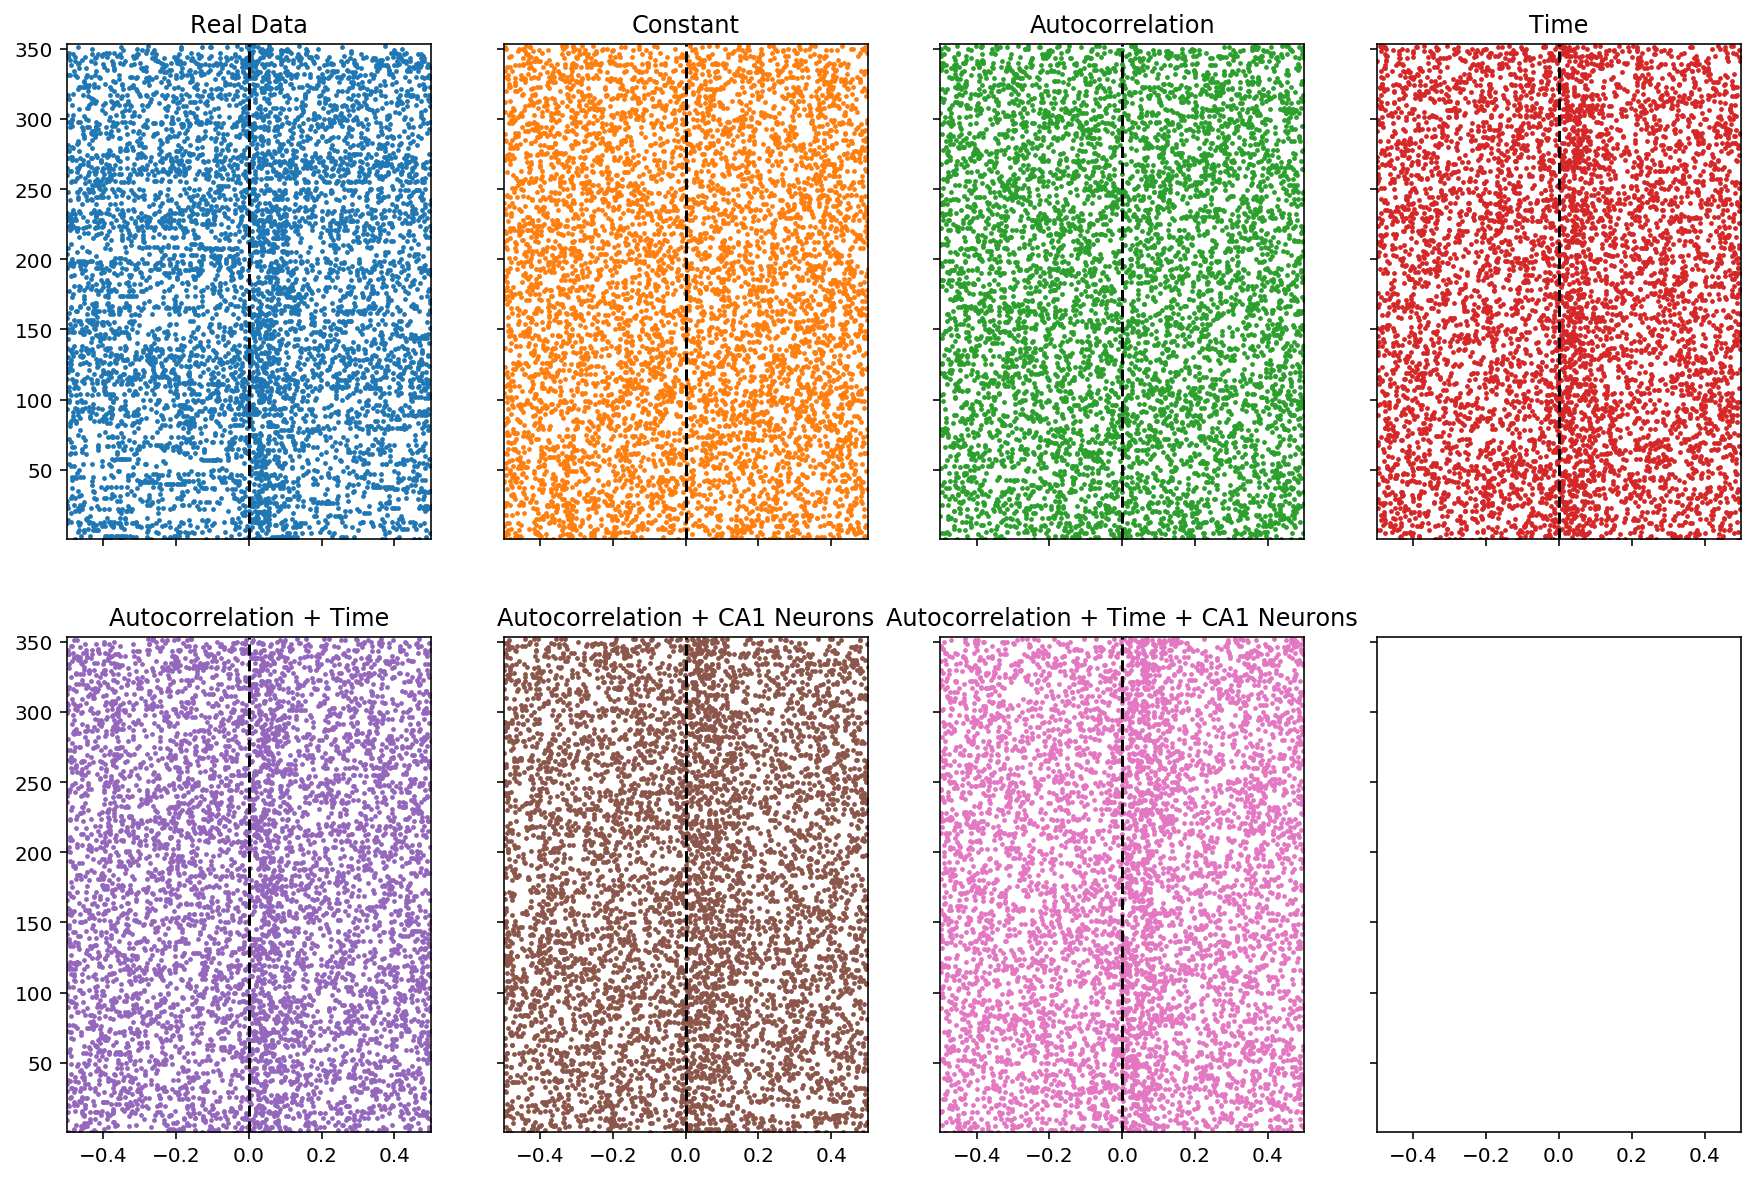

In [79]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
spike_index, event_index = np.nonzero(ripple_locked_spikes.unstack(level=0).values)
axes[0].scatter(unique_time[spike_index], event_index, s=2, color=color[0])
axes[0].set_title('Real Data')
axes[0].axvline(0, linestyle='--', color='black')
axes[0].set_xlim((-0.5, 0.5))
axes[0].set_ylim((1, len(ripple_times)))

spike_index, event_index = np.nonzero(simulated_spikes_constant)
axes[1].scatter(unique_time[spike_index], event_index, s=2, color=color[1])
axes[1].axvline(0, linestyle='--', color='black')
axes[1].set_title('Constant')

spike_index, event_index = np.nonzero(simulated_spikes_autocorrelation)
axes[2].scatter(unique_time[spike_index], event_index, s=2, color=color[2])
axes[2].axvline(0, linestyle='--', color='black')
axes[2].set_title('Autocorrelation')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time)
axes[3].scatter(unique_time[spike_index], event_index, s=2, color=color[3])
axes[3].axvline(0, linestyle='--', color='black')
axes[3].set_title('Time')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_autocorrelation)
axes[4].scatter(unique_time[spike_index], event_index, s=2, color=color[4])
axes[4].axvline(0, linestyle='--', color='black')
axes[4].set_title('Autocorrelation + Time')

spike_index, event_index = np.nonzero(simulated_spikes_other_spikes)
axes[5].scatter(unique_time[spike_index], event_index, s=2, color=color[5])
axes[5].axvline(0, linestyle='--', color='black')
axes[5].set_title('Autocorrelation + CA1 Neurons')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_with_other_neurons)
axes[6].scatter(unique_time[spike_index], event_index, s=2, color=color[6])
axes[6].axvline(0, linestyle='--', color='black')
axes[6].set_title('Autocorrelation + Time + CA1 Neurons');

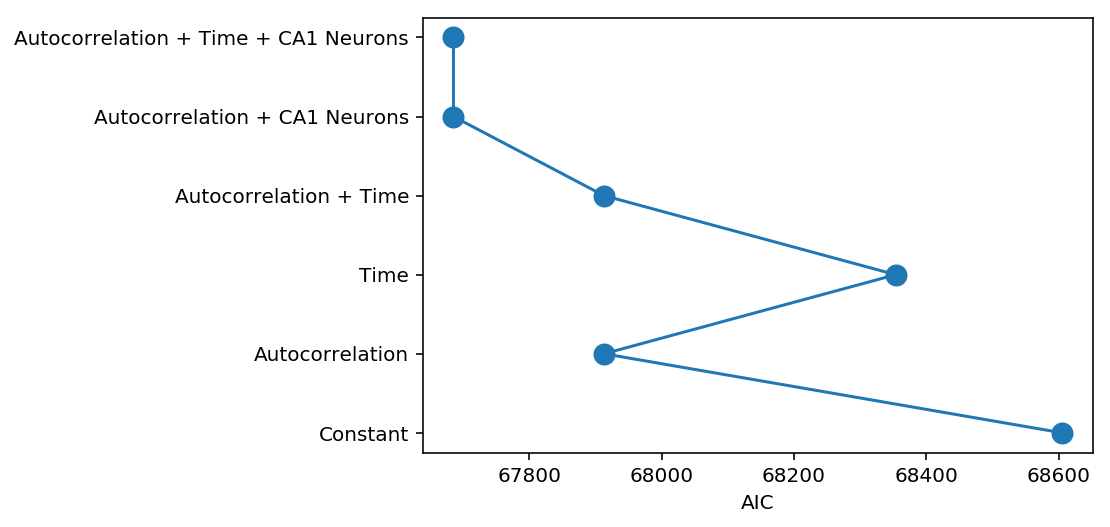

In [80]:
AIC = np.array(
    [results_constant.AIC,
     results_autocorrelation.AIC,
     results_ripple_time.AIC,
     results_ripple_time_autocorrelation.AIC,
     results_other_neurons.AIC,
     results_ripple_time_with_other_neurons.AIC,
    ])

plt.plot(AIC, np.arange(len(AIC)), '.-', markersize=20)
plt.xlabel('AIC')
plt.yticks(np.arange(len(AIC)),
           ['Constant', 'Autocorrelation', 'Time', 'Autocorrelation + Time',
            'Autocorrelation + CA1 Neurons', 'Autocorrelation + Time + CA1 Neurons']);

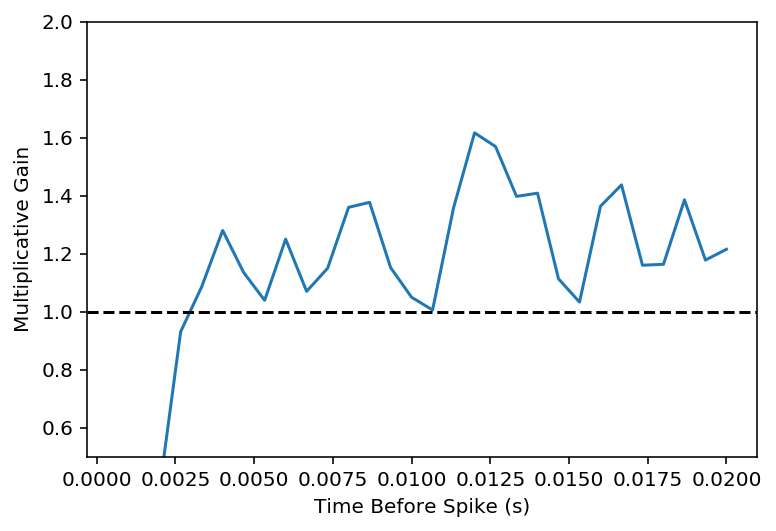

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_autocorrelation.coefficients[-n_lags:]))
ax.set_ylim((0.5, 2))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

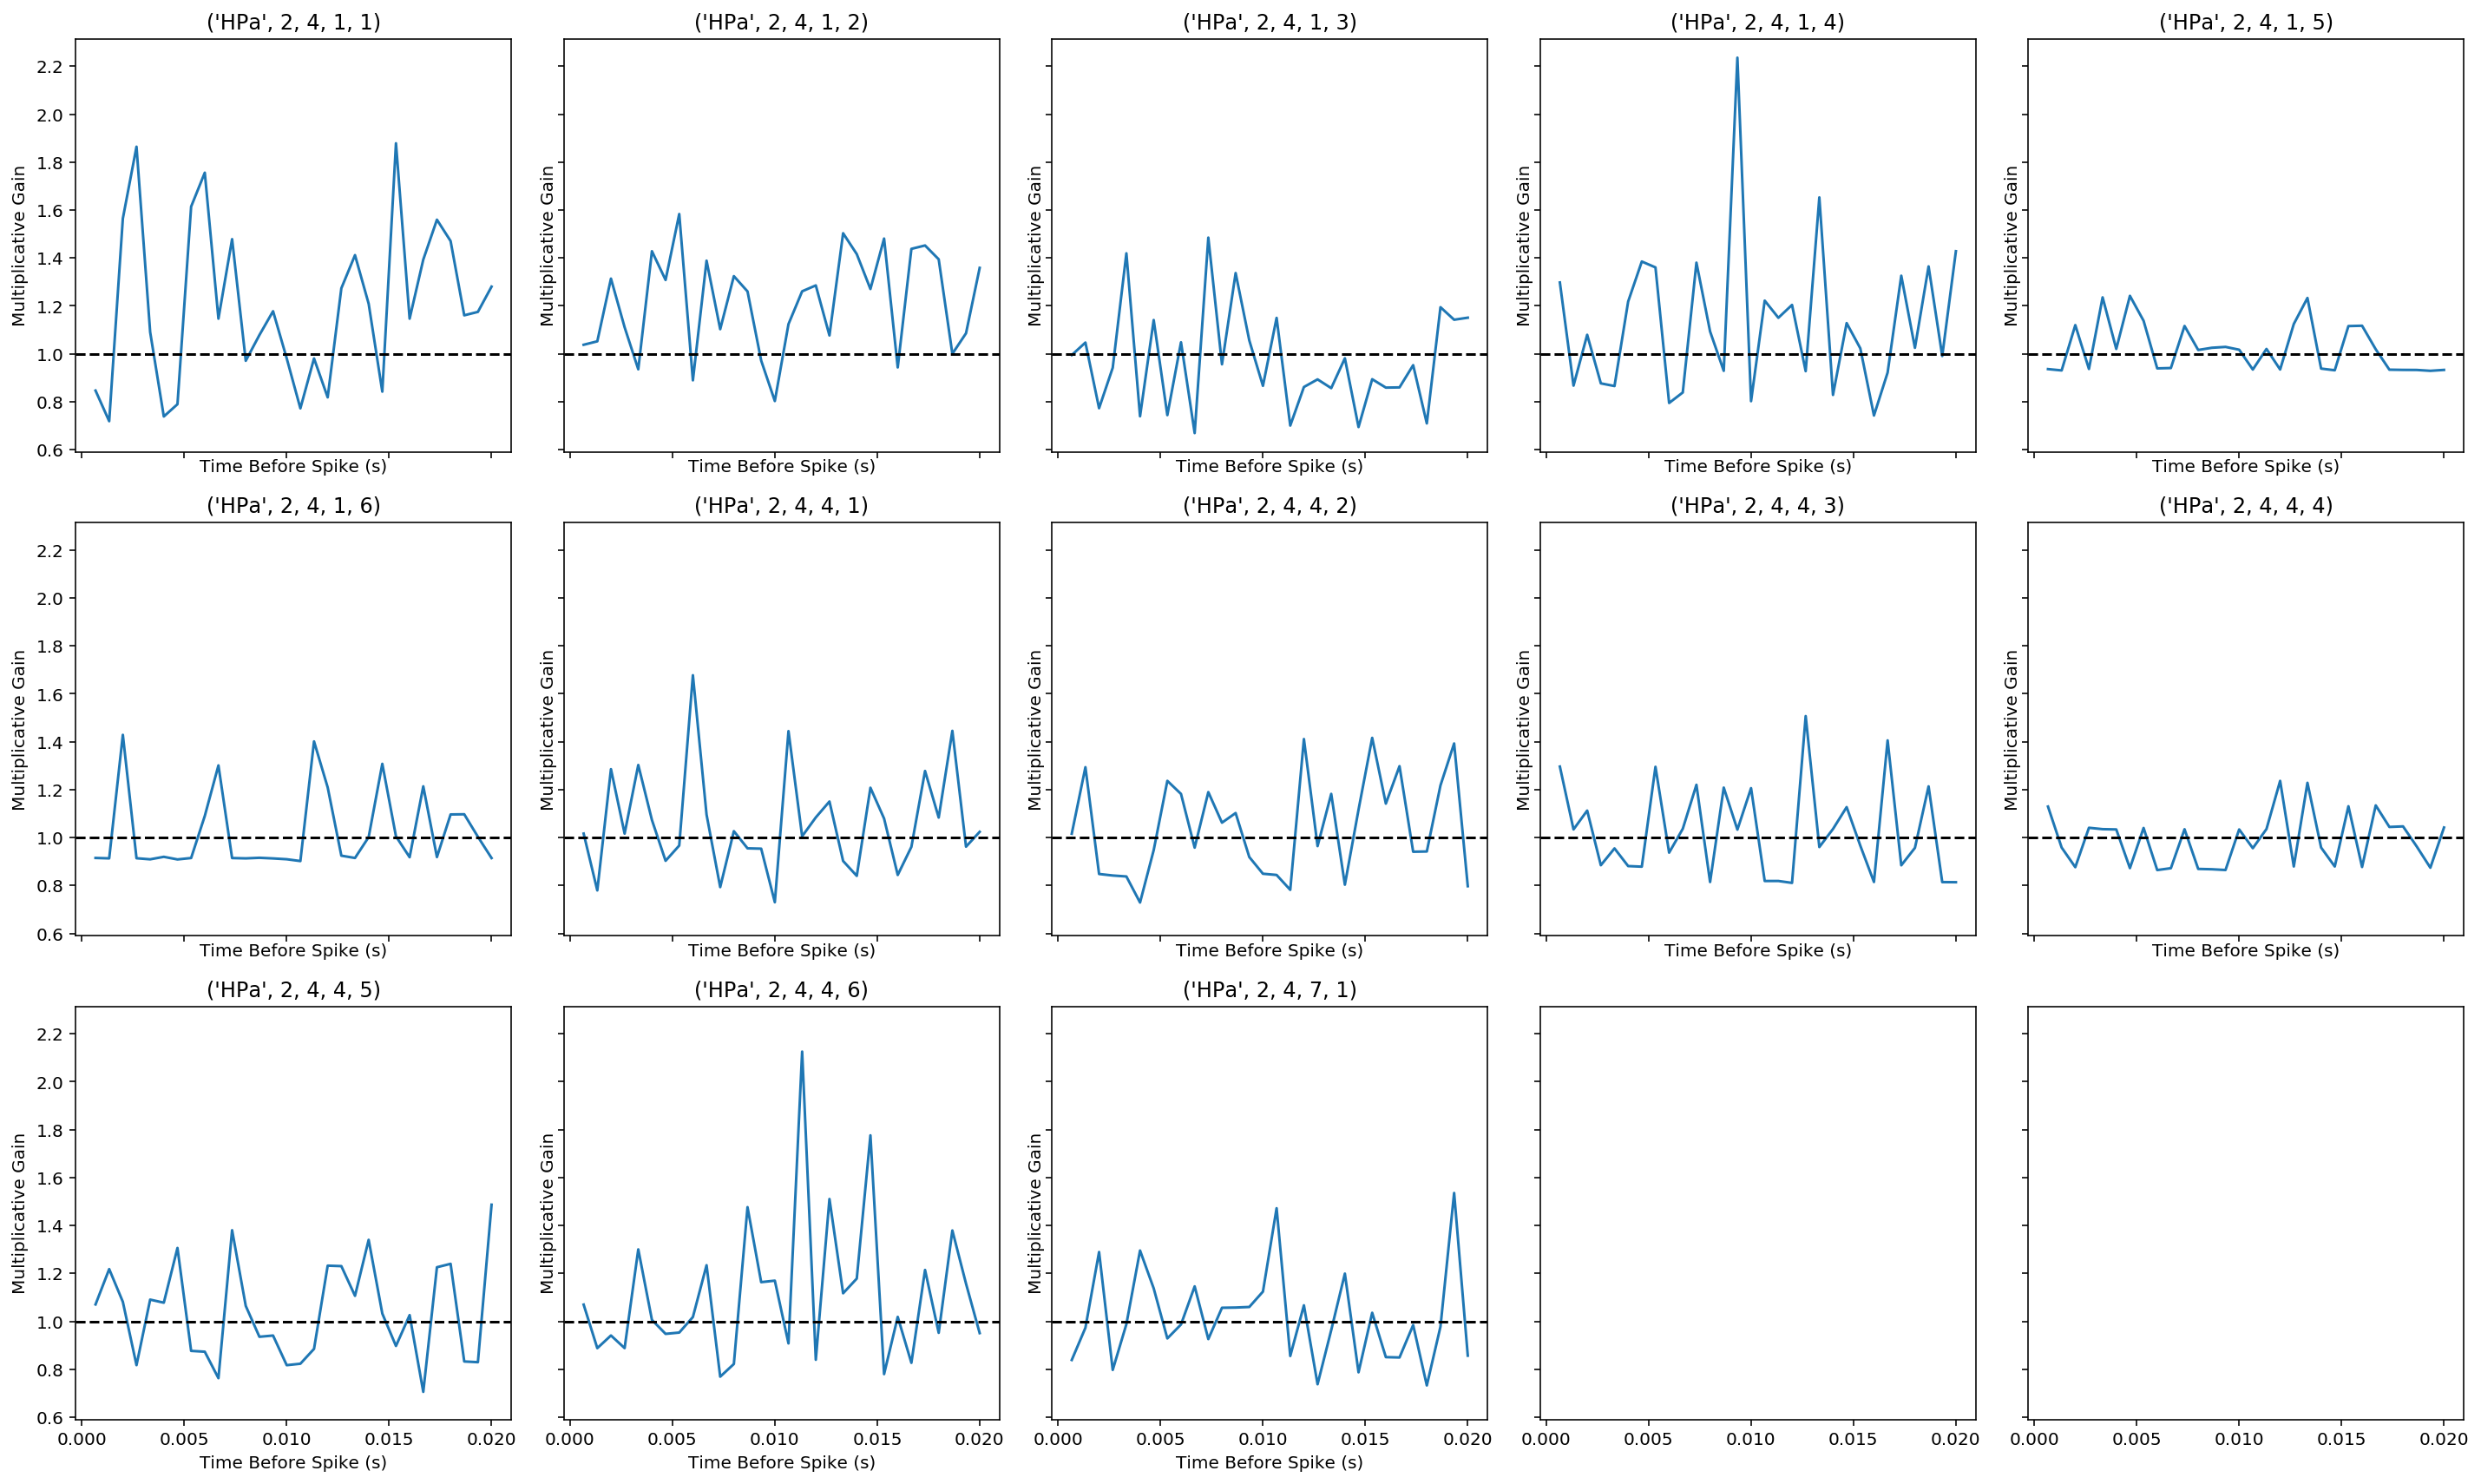

In [82]:

n_lags = 30
other_neurons = np.exp(results_other_neurons.coefficients[50:].reshape((-1, 30)))

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 4, n_rows * 4), sharex=True, sharey=True)

for ax, gain, key in zip(axes.ravel(), other_neurons, ca1_keys):
    ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY,
             gain)
    ax.axhline(1, color='black', linestyle='--');
    ax.set_ylabel('Multiplicative Gain')
    ax.set_xlabel('Time Before Spike (s)');
    ax.set_title(key)

plt.tight_layout()

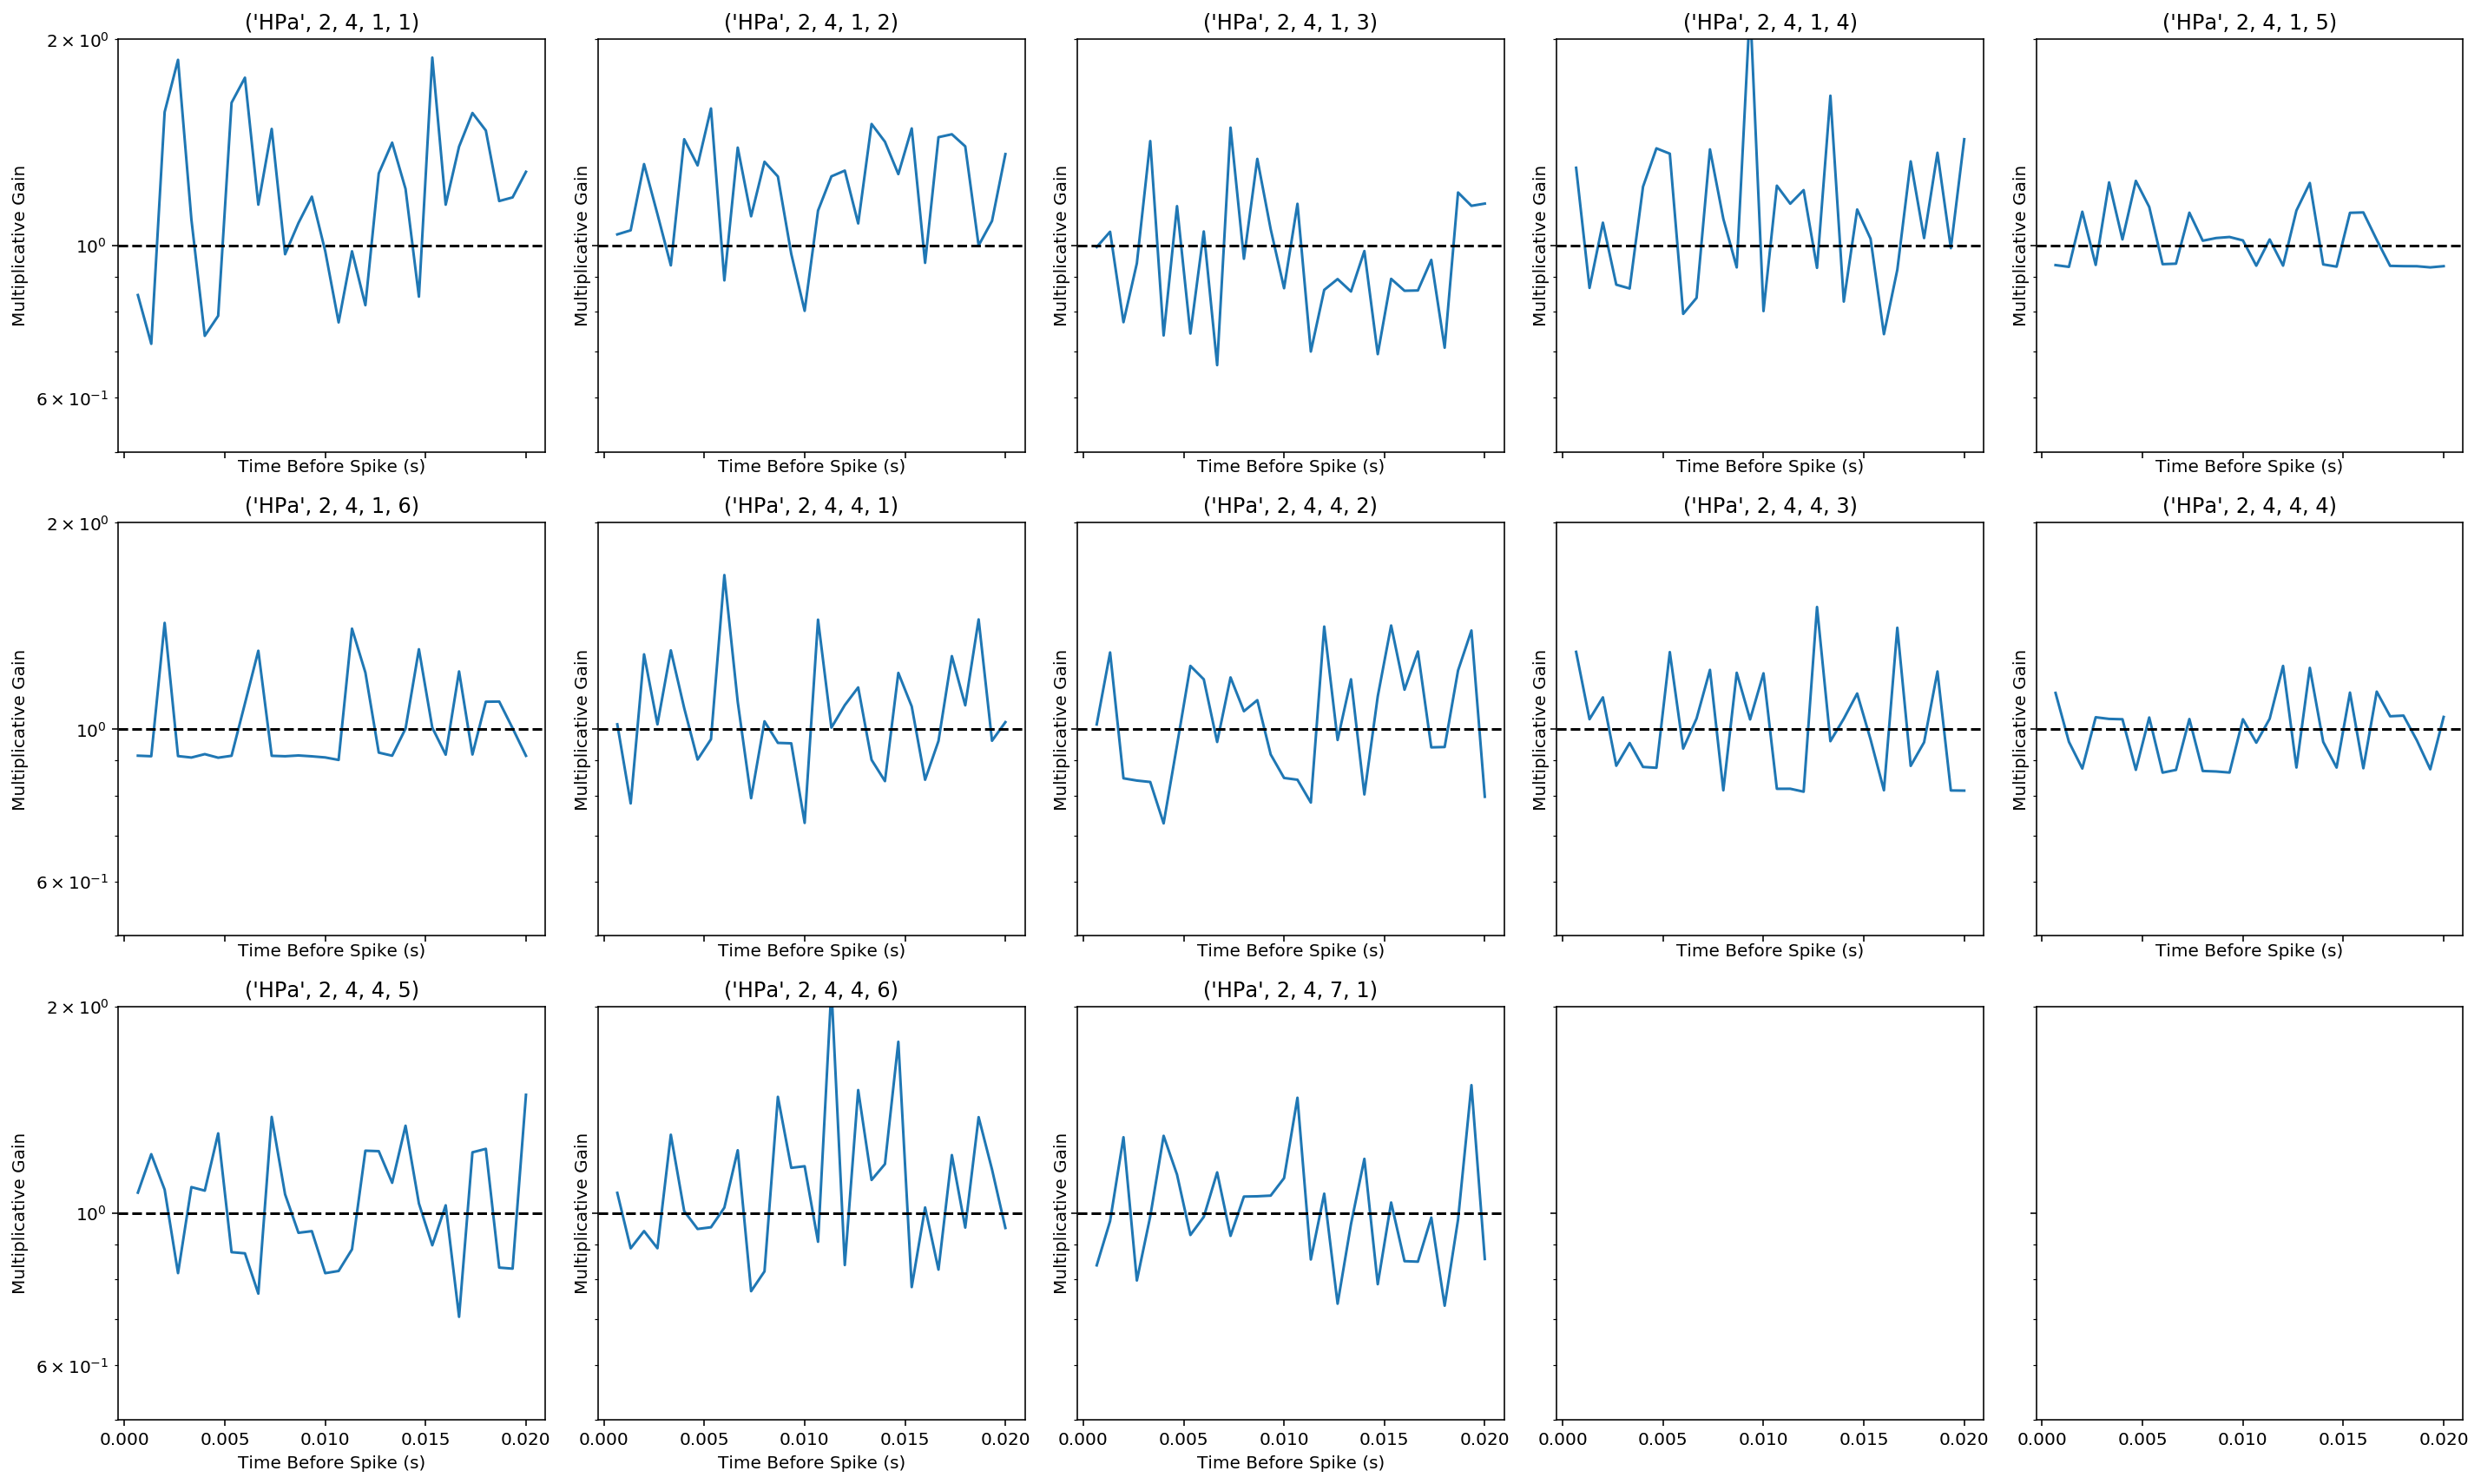

In [90]:

n_lags = 30
other_neurons = np.exp(results_other_neurons.coefficients[50:].reshape((-1, 30)))

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 4, n_rows * 4), sharex=True, sharey=True)

for ax, gain, key in zip(axes.ravel(), other_neurons, ca1_keys):
    ax.semilogy((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY,
             gain)
    ax.axhline(1, color='black', linestyle='--');
    ax.set_ylabel('Multiplicative Gain')
    ax.set_xlabel('Time Before Spike (s)');
    ax.set_title(key)

plt.ylim((1/2, 2))
plt.tight_layout()

### CA1 Neuron
#### ('HPa', 2, 4, 1, 4)

In [91]:
penalty = 1E1

pfc_neuron_keys = [('HPa', 2, 4, 17, 2)]
neuron_key = ('HPa', 2, 4, 1, 4)

results_constant, simulated_spikes_constant = fit_constant(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY)
results_ripple_time, simulated_spikes_ripple_time = fit_ripple_time(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_autocorrelation = fit_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_ripple_time_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_other_neurons, simulated_spikes_other_spikes = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=pfc_neuron_keys, penalty=penalty)
results_ripple_time_with_other_neurons, simulated_spikes_ripple_time_with_other_neurons = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=pfc_neuron_keys, penalty=penalty)

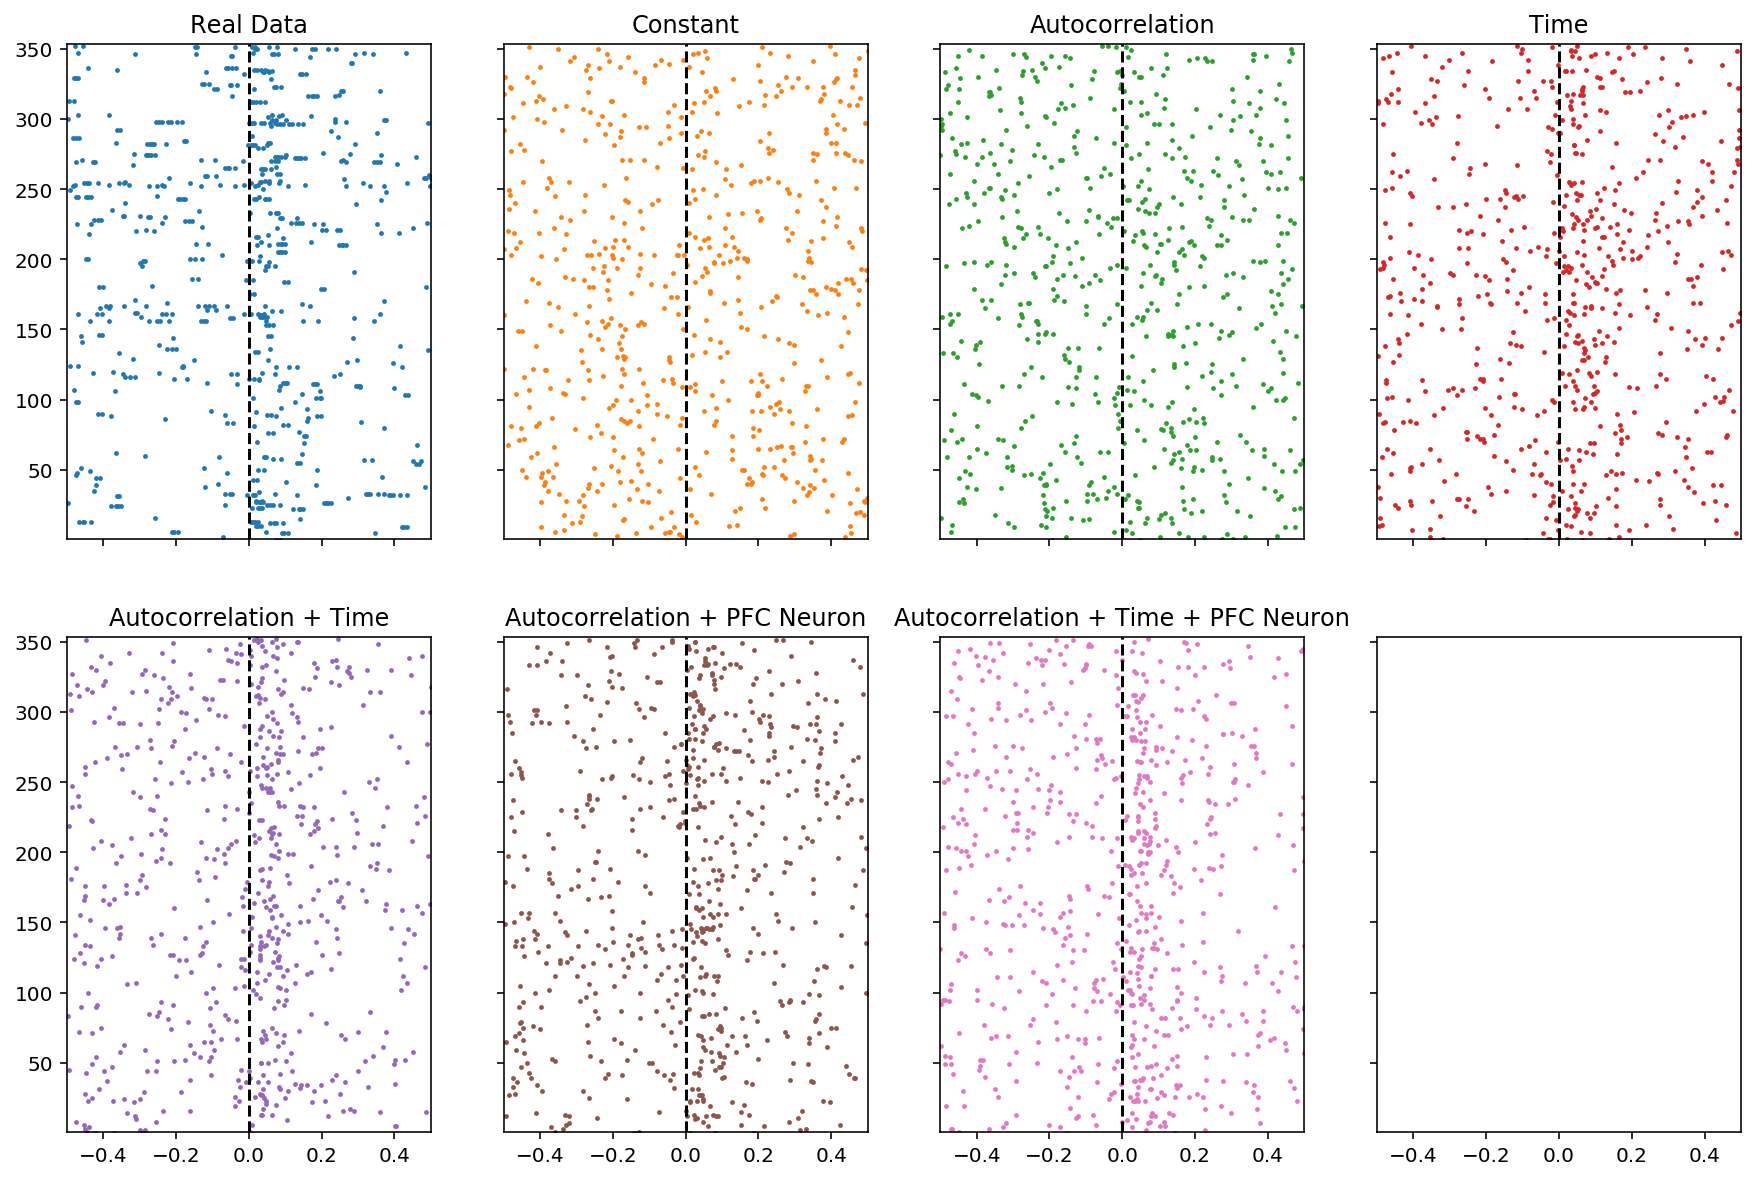

In [104]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

ripple_locked_spikes = get_trial_spikes2(
    neuron_key, ANIMALS, ripple_times,
    (-0.5, 0.5), SAMPLING_FREQUENCY)
time = ripple_locked_spikes.index.get_level_values('time')
unique_time = np.unique(time.total_seconds().values)

fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
spike_index, event_index = np.nonzero(ripple_locked_spikes.unstack(level=0).values)
axes[0].scatter(unique_time[spike_index], event_index, s=2, color=color[0])
axes[0].set_title('Real Data')
axes[0].axvline(0, linestyle='--', color='black')
axes[0].set_xlim((-0.5, 0.5))
axes[0].set_ylim((1, len(ripple_times)))

spike_index, event_index = np.nonzero(simulated_spikes_constant)
axes[1].scatter(unique_time[spike_index], event_index, s=2, color=color[1])
axes[1].axvline(0, linestyle='--', color='black')
axes[1].set_title('Constant')

spike_index, event_index = np.nonzero(simulated_spikes_autocorrelation)
axes[2].scatter(unique_time[spike_index], event_index, s=2, color=color[2])
axes[2].axvline(0, linestyle='--', color='black')
axes[2].set_title('Autocorrelation')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time)
axes[3].scatter(unique_time[spike_index], event_index, s=2, color=color[3])
axes[3].axvline(0, linestyle='--', color='black')
axes[3].set_title('Time')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_autocorrelation)
axes[4].scatter(unique_time[spike_index], event_index, s=2, color=color[4])
axes[4].axvline(0, linestyle='--', color='black')
axes[4].set_title('Autocorrelation + Time')

spike_index, event_index = np.nonzero(simulated_spikes_other_spikes)
axes[5].scatter(unique_time[spike_index], event_index, s=2, color=color[5])
axes[5].axvline(0, linestyle='--', color='black')
axes[5].set_title('Autocorrelation + PFC Neuron')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_with_other_neurons)
axes[6].scatter(unique_time[spike_index], event_index, s=2, color=color[6])
axes[6].axvline(0, linestyle='--', color='black')
axes[6].set_title('Autocorrelation + Time + PFC Neuron');

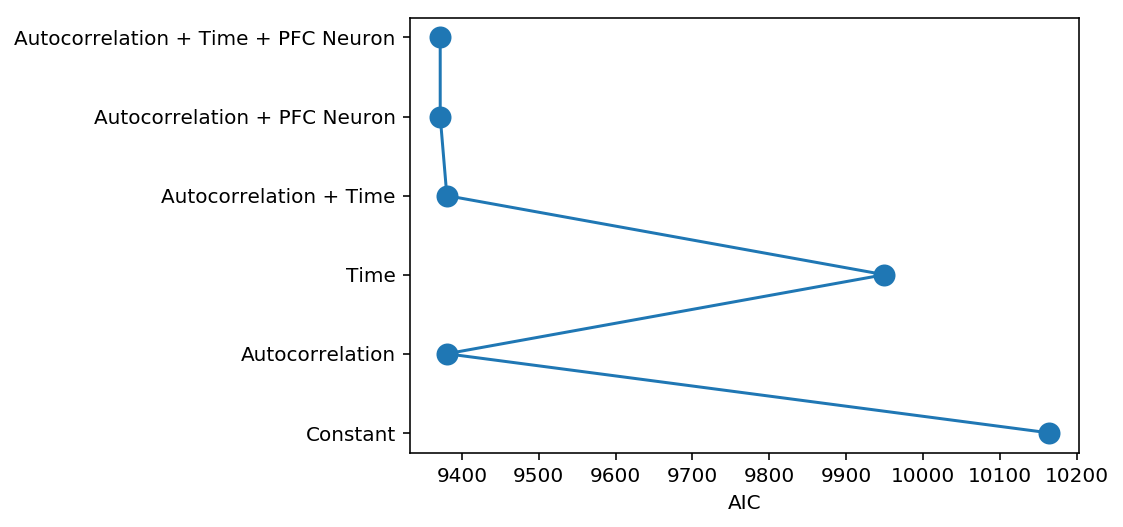

In [105]:
AIC = np.array(
    [results_constant.AIC,
     results_autocorrelation.AIC,
     results_ripple_time.AIC,
     results_ripple_time_autocorrelation.AIC,
     results_other_neurons.AIC,
     results_ripple_time_with_other_neurons.AIC,
    ])

plt.plot(AIC, np.arange(len(AIC)), '.-', markersize=20)
plt.xlabel('AIC')
plt.yticks(np.arange(len(AIC)),
           ['Constant', 'Autocorrelation', 'Time', 'Autocorrelation + Time',
            'Autocorrelation + PFC Neuron', 'Autocorrelation + Time + PFC Neuron']);

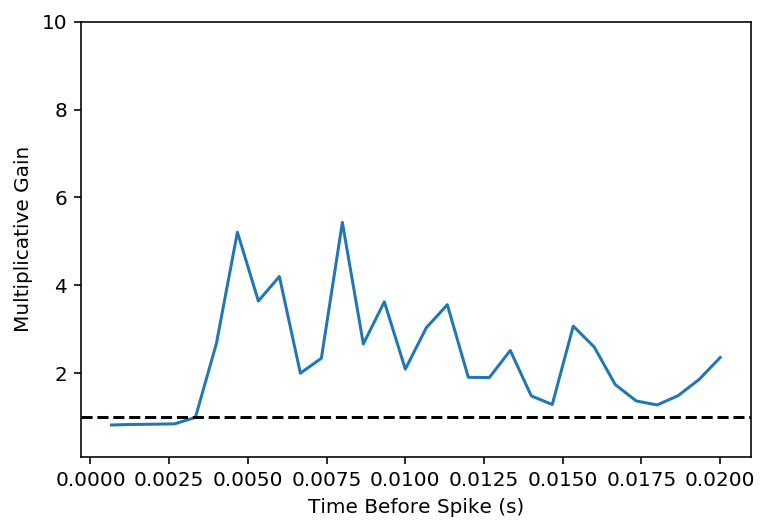

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_autocorrelation.coefficients[-n_lags:]))
ax.set_ylim((1E-1, 1E1))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

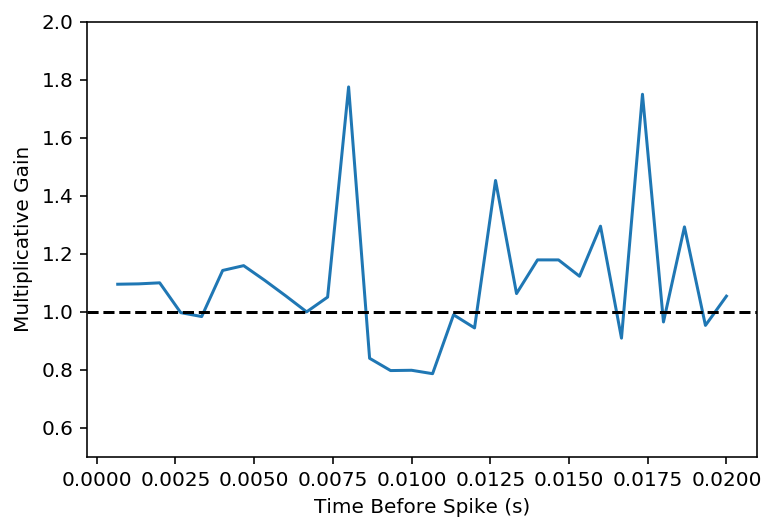

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_other_neurons.coefficients[-n_lags:]))
ax.set_ylim((0.5, 2))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

#### ('HPa', 2, 4, 4, 2)

In [113]:
penalty = 1E1

pfc_neuron_keys = [('HPa', 2, 4, 17, 2)]
neuron_key = ('HPa', 2, 4, 4, 2)

results_constant, simulated_spikes_constant = fit_constant(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY)
results_ripple_time, simulated_spikes_ripple_time = fit_ripple_time(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_autocorrelation = fit_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_ripple_time_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_other_neurons, simulated_spikes_other_spikes = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=pfc_neuron_keys, penalty=penalty)
results_ripple_time_with_other_neurons, simulated_spikes_ripple_time_with_other_neurons = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=pfc_neuron_keys, penalty=penalty)

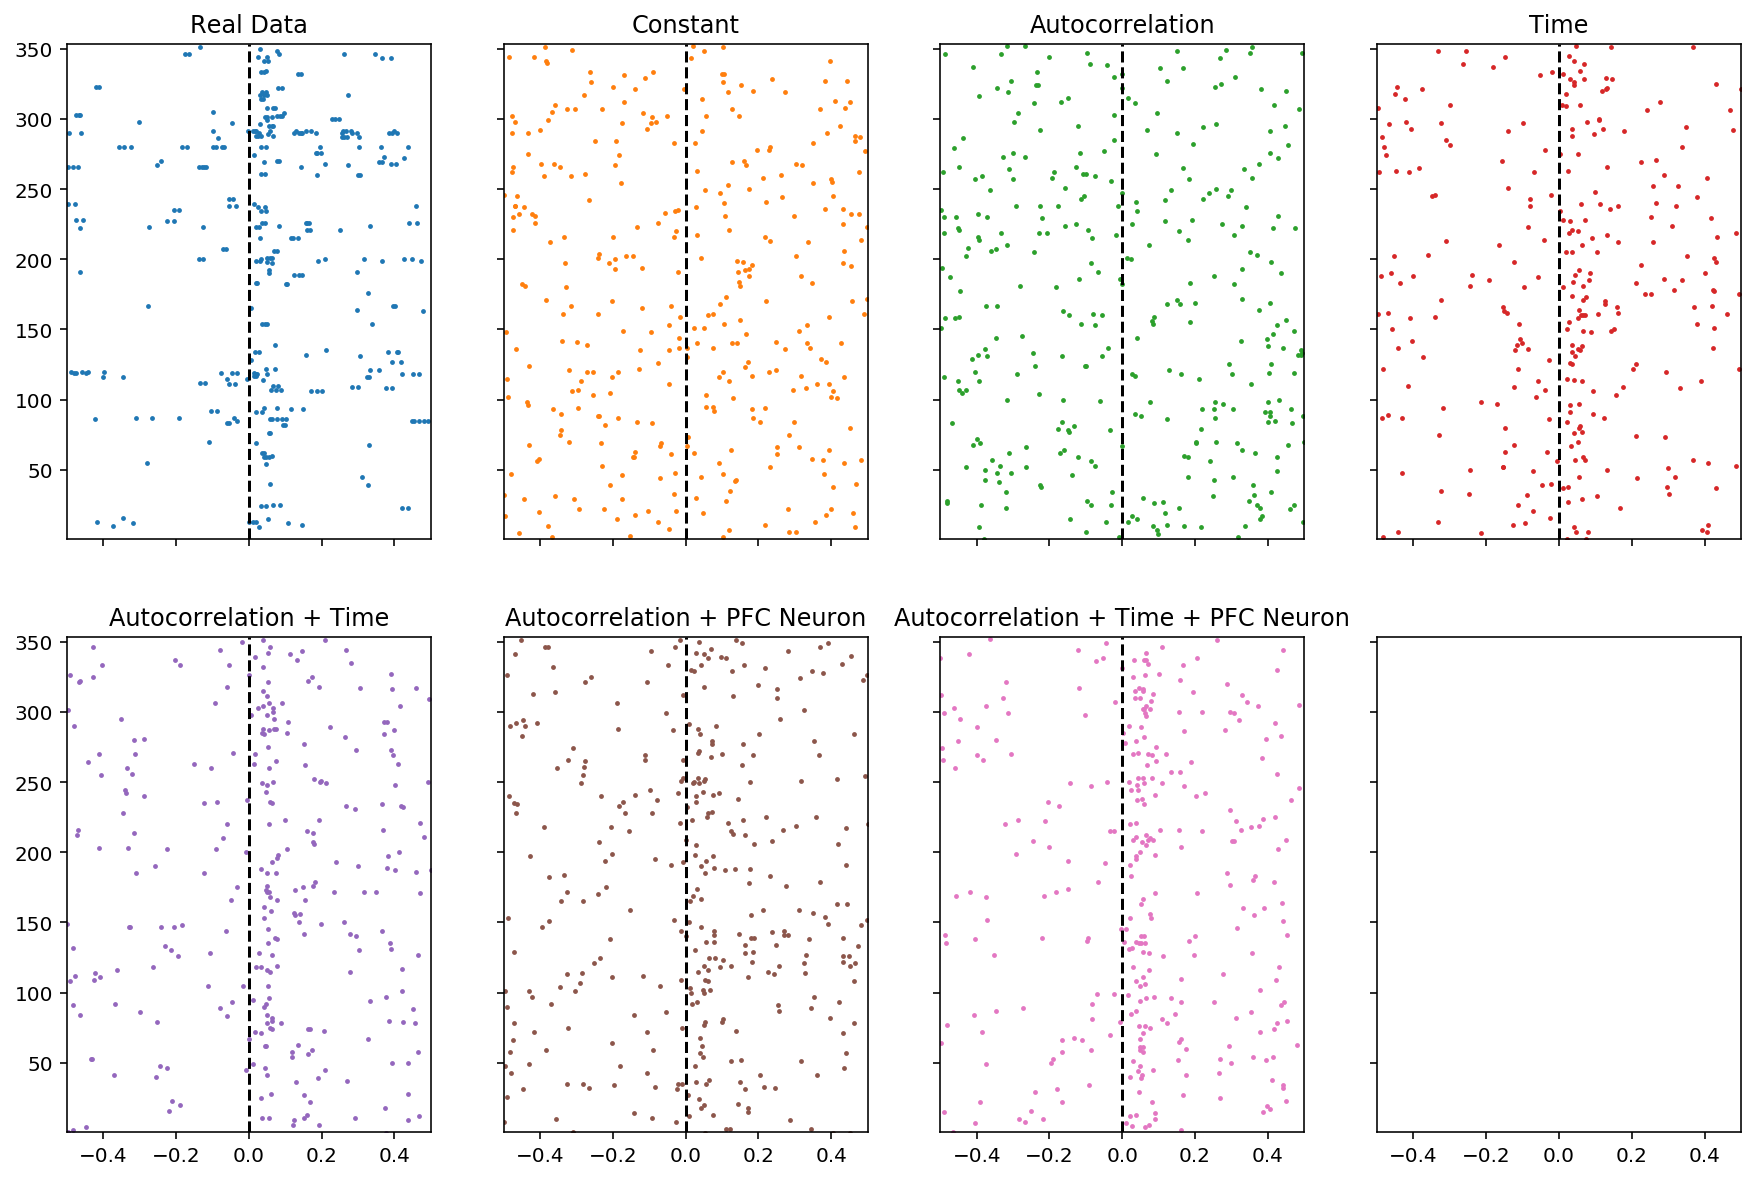

In [114]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

ripple_locked_spikes = get_trial_spikes2(
    neuron_key, ANIMALS, ripple_times,
    (-0.5, 0.5), SAMPLING_FREQUENCY)
time = ripple_locked_spikes.index.get_level_values('time')
unique_time = np.unique(time.total_seconds().values)

fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
spike_index, event_index = np.nonzero(ripple_locked_spikes.unstack(level=0).values)
axes[0].scatter(unique_time[spike_index], event_index, s=2, color=color[0])
axes[0].set_title('Real Data')
axes[0].axvline(0, linestyle='--', color='black')
axes[0].set_xlim((-0.5, 0.5))
axes[0].set_ylim((1, len(ripple_times)))

spike_index, event_index = np.nonzero(simulated_spikes_constant)
axes[1].scatter(unique_time[spike_index], event_index, s=2, color=color[1])
axes[1].axvline(0, linestyle='--', color='black')
axes[1].set_title('Constant')

spike_index, event_index = np.nonzero(simulated_spikes_autocorrelation)
axes[2].scatter(unique_time[spike_index], event_index, s=2, color=color[2])
axes[2].axvline(0, linestyle='--', color='black')
axes[2].set_title('Autocorrelation')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time)
axes[3].scatter(unique_time[spike_index], event_index, s=2, color=color[3])
axes[3].axvline(0, linestyle='--', color='black')
axes[3].set_title('Time')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_autocorrelation)
axes[4].scatter(unique_time[spike_index], event_index, s=2, color=color[4])
axes[4].axvline(0, linestyle='--', color='black')
axes[4].set_title('Autocorrelation + Time')

spike_index, event_index = np.nonzero(simulated_spikes_other_spikes)
axes[5].scatter(unique_time[spike_index], event_index, s=2, color=color[5])
axes[5].axvline(0, linestyle='--', color='black')
axes[5].set_title('Autocorrelation + PFC Neuron')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_with_other_neurons)
axes[6].scatter(unique_time[spike_index], event_index, s=2, color=color[6])
axes[6].axvline(0, linestyle='--', color='black')
axes[6].set_title('Autocorrelation + Time + PFC Neuron');

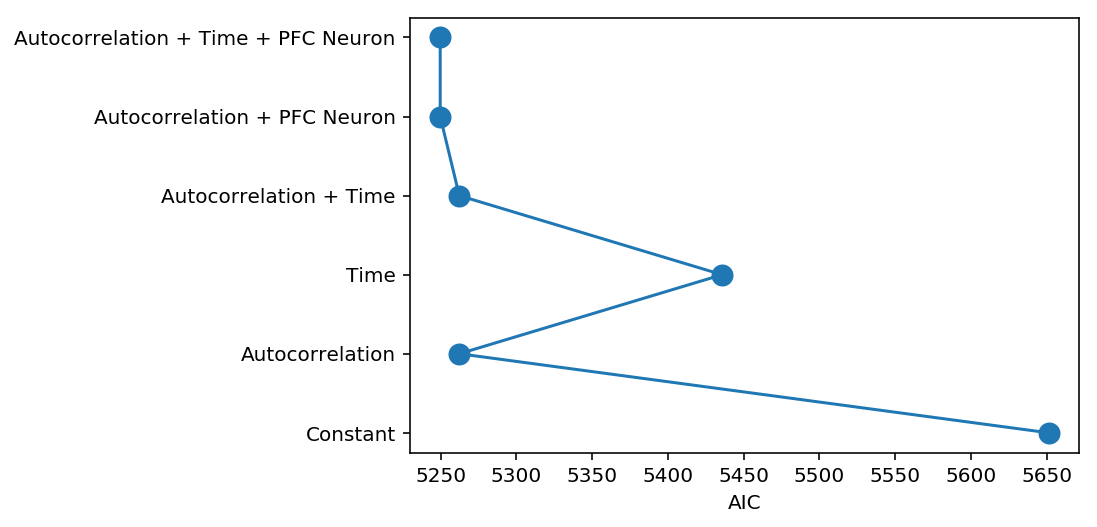

In [119]:
AIC = np.array(
    [results_constant.AIC,
     results_autocorrelation.AIC,
     results_ripple_time.AIC,
     results_ripple_time_autocorrelation.AIC,
     results_other_neurons.AIC,
     results_ripple_time_with_other_neurons.AIC,
    ])

plt.plot(AIC, np.arange(len(AIC)), '.-', markersize=20)
plt.xlabel('AIC')
plt.yticks(np.arange(len(AIC)),
           ['Constant', 'Autocorrelation', 'Time', 'Autocorrelation + Time',
            'Autocorrelation + PFC Neuron', 'Autocorrelation + Time + PFC Neuron']);

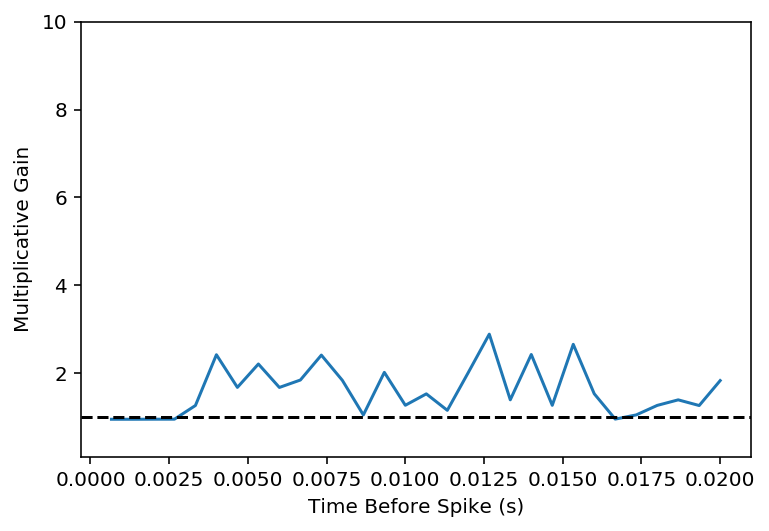

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_autocorrelation.coefficients[-n_lags:]))
ax.set_ylim((1E-1, 1E1))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

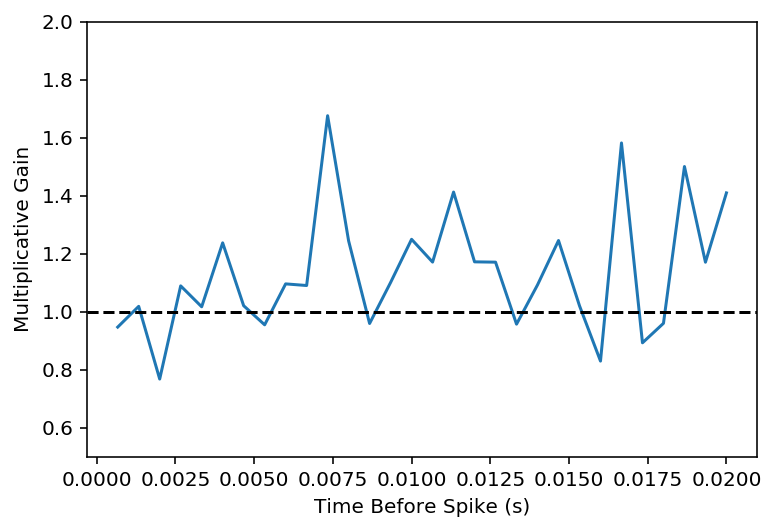

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_other_neurons.coefficients[-n_lags:]))
ax.set_ylim((0.5, 2))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

#### ('HPa', 2, 4, 1, 2)

In [121]:
penalty = 1E1

pfc_neuron_keys = [('HPa', 2, 4, 17, 2)]
neuron_key = ('HPa', 2, 4, 1, 2)

results_constant, simulated_spikes_constant = fit_constant(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY)
results_ripple_time, simulated_spikes_ripple_time = fit_ripple_time(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_autocorrelation = fit_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_ripple_time_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_autocorrelation, simulated_spikes_ripple_time_autocorrelation = fit_ripple_time_with_autocorrelation(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY, penalty=penalty)
results_other_neurons, simulated_spikes_other_spikes = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=pfc_neuron_keys, penalty=penalty)
results_ripple_time_with_other_neurons, simulated_spikes_ripple_time_with_other_neurons = fit_ripple_time_with_other_neurons(
    neuron_key, ANIMALS, SAMPLING_FREQUENCY,
    ripple_times, other_neurons=pfc_neuron_keys, penalty=penalty)

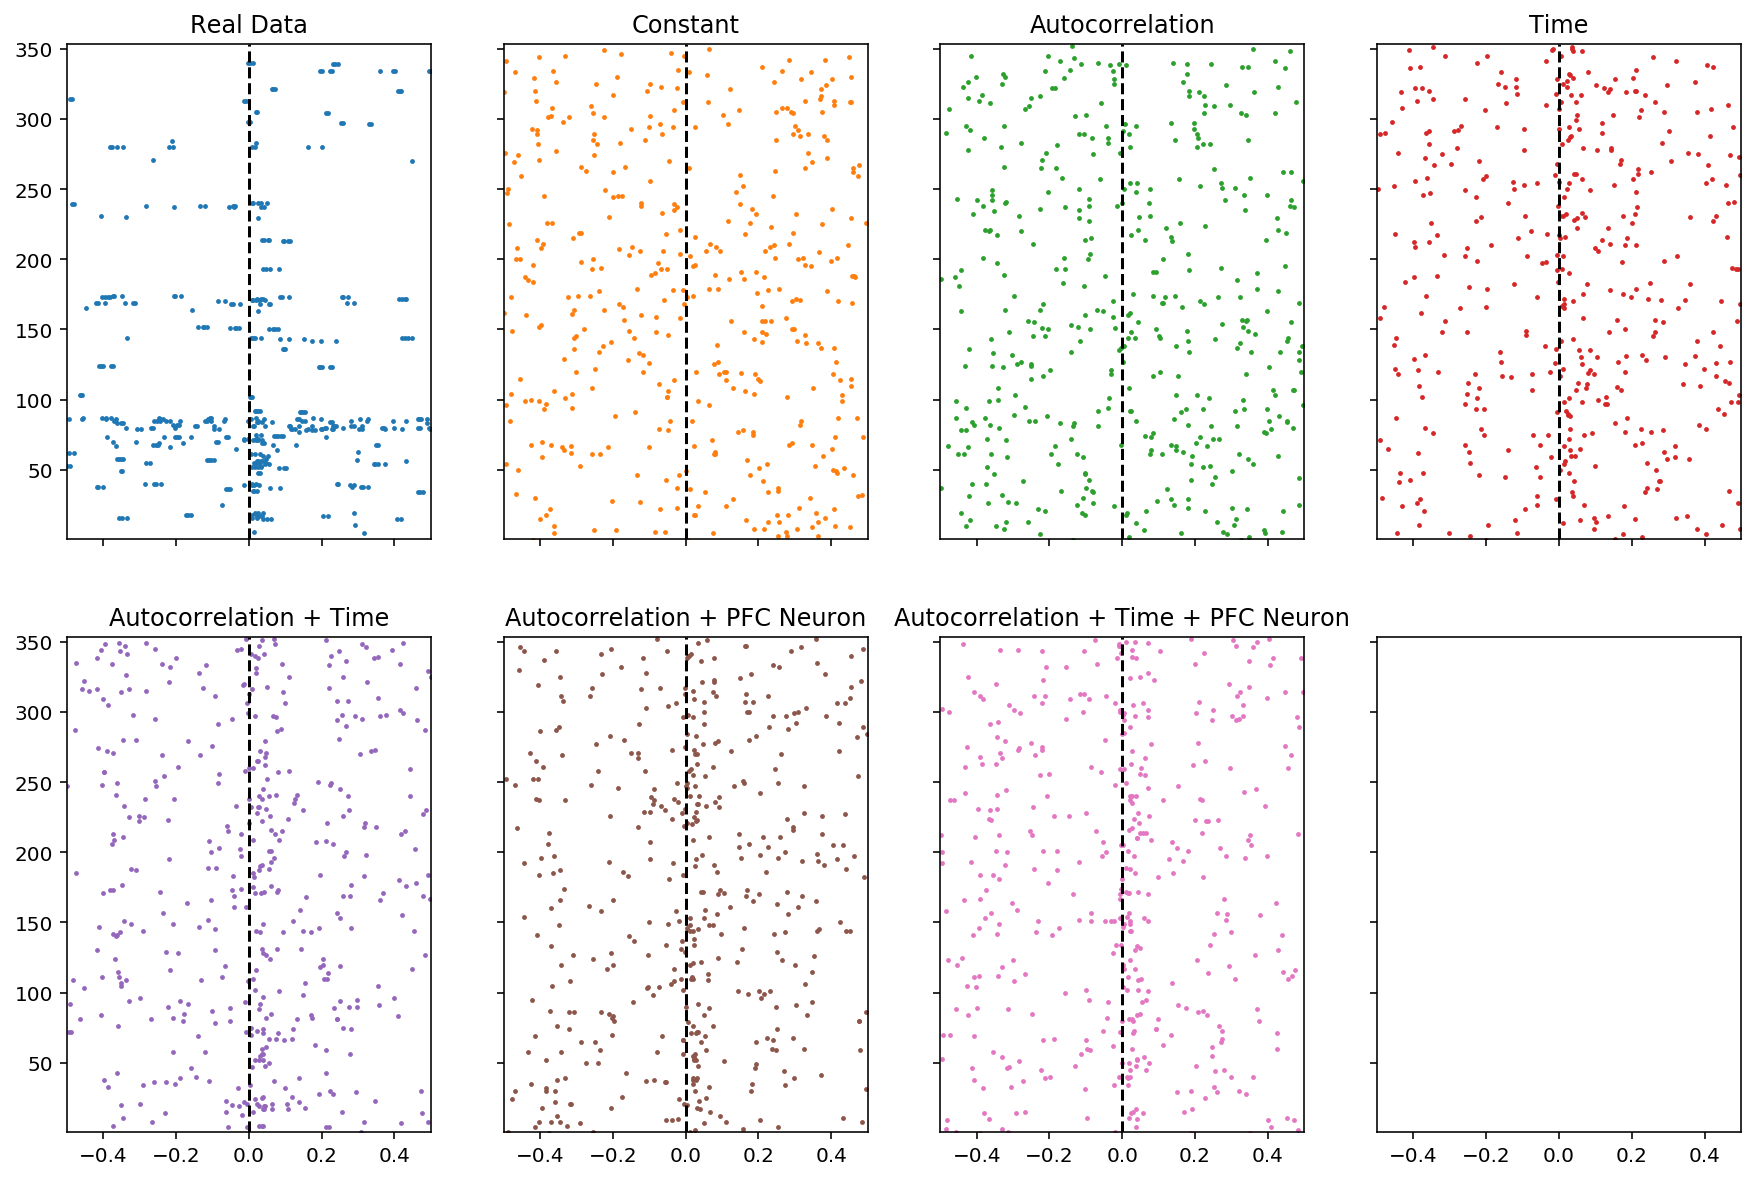

In [122]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

ripple_locked_spikes = get_trial_spikes2(
    neuron_key, ANIMALS, ripple_times,
    (-0.5, 0.5), SAMPLING_FREQUENCY)
time = ripple_locked_spikes.index.get_level_values('time')
unique_time = np.unique(time.total_seconds().values)

fig, axes = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
spike_index, event_index = np.nonzero(ripple_locked_spikes.unstack(level=0).values)
axes[0].scatter(unique_time[spike_index], event_index, s=2, color=color[0])
axes[0].set_title('Real Data')
axes[0].axvline(0, linestyle='--', color='black')
axes[0].set_xlim((-0.5, 0.5))
axes[0].set_ylim((1, len(ripple_times)))

spike_index, event_index = np.nonzero(simulated_spikes_constant)
axes[1].scatter(unique_time[spike_index], event_index, s=2, color=color[1])
axes[1].axvline(0, linestyle='--', color='black')
axes[1].set_title('Constant')

spike_index, event_index = np.nonzero(simulated_spikes_autocorrelation)
axes[2].scatter(unique_time[spike_index], event_index, s=2, color=color[2])
axes[2].axvline(0, linestyle='--', color='black')
axes[2].set_title('Autocorrelation')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time)
axes[3].scatter(unique_time[spike_index], event_index, s=2, color=color[3])
axes[3].axvline(0, linestyle='--', color='black')
axes[3].set_title('Time')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_autocorrelation)
axes[4].scatter(unique_time[spike_index], event_index, s=2, color=color[4])
axes[4].axvline(0, linestyle='--', color='black')
axes[4].set_title('Autocorrelation + Time')

spike_index, event_index = np.nonzero(simulated_spikes_other_spikes)
axes[5].scatter(unique_time[spike_index], event_index, s=2, color=color[5])
axes[5].axvline(0, linestyle='--', color='black')
axes[5].set_title('Autocorrelation + PFC Neuron')

spike_index, event_index = np.nonzero(simulated_spikes_ripple_time_with_other_neurons)
axes[6].scatter(unique_time[spike_index], event_index, s=2, color=color[6])
axes[6].axvline(0, linestyle='--', color='black')
axes[6].set_title('Autocorrelation + Time + PFC Neuron');

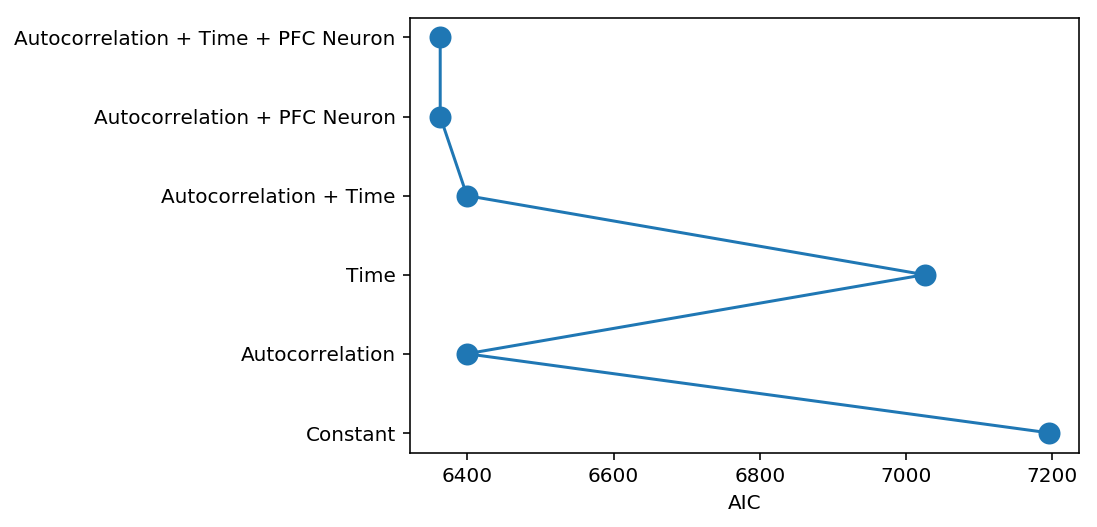

In [123]:
AIC = np.array(
    [results_constant.AIC,
     results_autocorrelation.AIC,
     results_ripple_time.AIC,
     results_ripple_time_autocorrelation.AIC,
     results_other_neurons.AIC,
     results_ripple_time_with_other_neurons.AIC,
    ])

plt.plot(AIC, np.arange(len(AIC)), '.-', markersize=20)
plt.xlabel('AIC')
plt.yticks(np.arange(len(AIC)),
           ['Constant', 'Autocorrelation', 'Time', 'Autocorrelation + Time',
            'Autocorrelation + PFC Neuron', 'Autocorrelation + Time + PFC Neuron']);

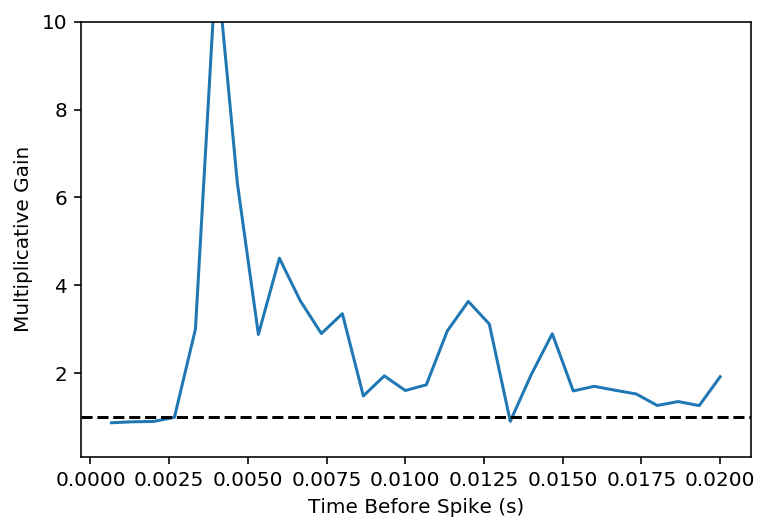

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_autocorrelation.coefficients[-n_lags:]))
ax.set_ylim((1E-1, 1E1))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

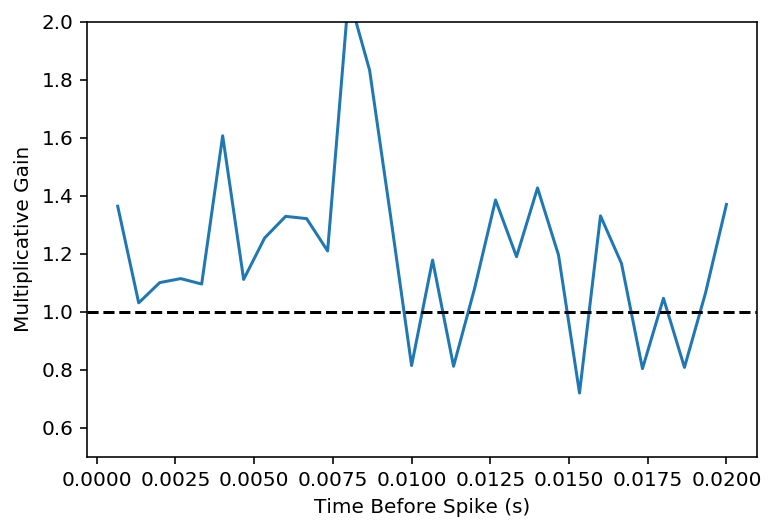

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_lags = 30
ax.plot((np.arange(n_lags) + 1) / SAMPLING_FREQUENCY, np.exp(results_other_neurons.coefficients[-n_lags:]))
ax.set_ylim((0.5, 2))
ax.axhline(1, color='black', linestyle='--');
ax.set_ylabel('Multiplicative Gain')
ax.set_xlabel('Time Before Spike (s)');

In [109]:
neuron_key = ('HPa', 2, 4, 1, 3)
ripple_locked_spikes = get_trial_spikes(neuron_key, ANIMALS, ripple_times)

In [110]:
if ripple_locked_spikes.values.sum() > 50:
    pass

In [111]:
def jitter(ripple_locked_spikes):
    n_time = ripple_locked_spikes.shape[0]
    return np.stack(
        [np.roll(trial_spikes, np.random.randint(-n_time, n_time))
         for trial_spikes in ripple_locked_spikes.T], axis=1)
        

In [112]:
n_shuffle = 5000
shuffled_spikes = np.stack([jitter(ripple_locked_spikes.values).mean(axis=1)
                            for _ in range(n_shuffle)], axis=1)

In [113]:
baseline = shuffled_spikes.mean(axis=1)

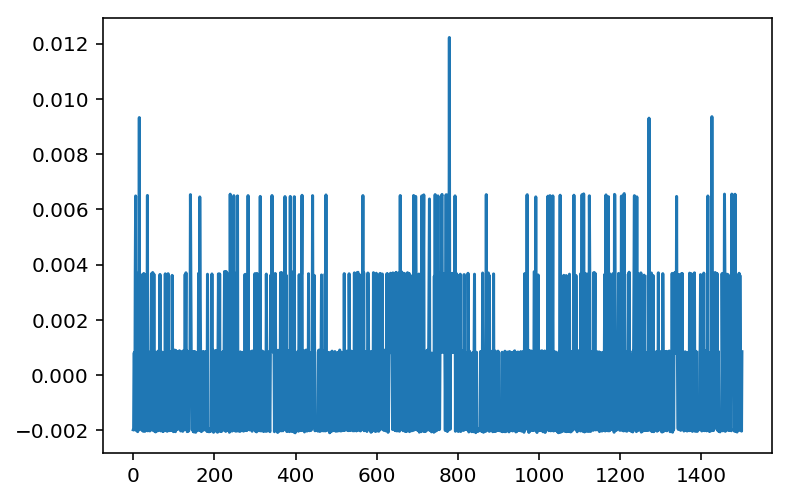

In [114]:
plt.plot(ripple_locked_spikes.values.mean(axis=1) - baseline)

In [115]:
t = ripple_locked_spikes.index.total_seconds();
is_after_swr = (t >= 0.0) & (t <= 0.2)

null = np.mean((shuffled_spikes[is_after_swr] - baseline[is_after_swr, np.newaxis]) ** 2, axis=1)
test_stat = np.mean((ripple_locked_spikes.values.mean(axis=1)[is_after_swr] - baseline[is_after_swr]) ** 2)

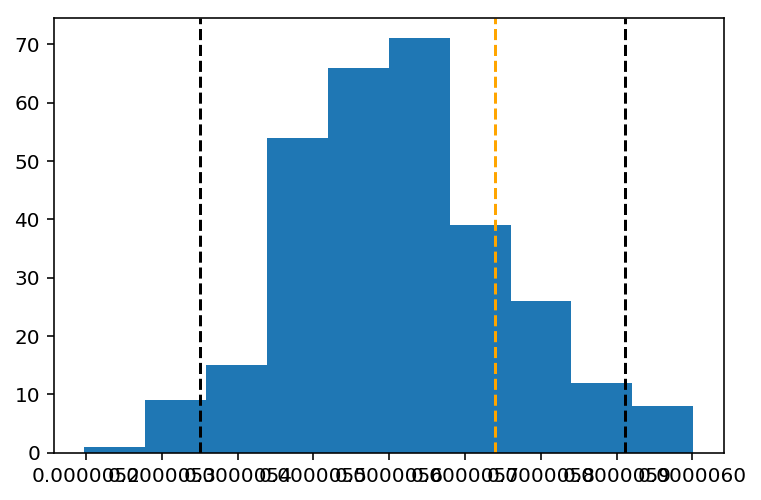

In [118]:
plt.hist(null);
plt.gca().axvline(test_stat, color='orange', linestyle='--')

for ci in np.percentile(null, [2.5, 97.5]):
    plt.gca().axvline(ci, color='black', linestyle='--')

In [120]:
 min_null, max_null = np.percentile(null, [2.5, 97.5])
(test_stat < min_null) | (test_stat > max_null)

False

In [602]:
epoch_info = make_epochs_dataframe(ANIMALS)
# epoch_keys = epoch_info[(epoch_info.type == 'run') & (
#     epoch_info.environment != 'lin')].index
epoch_keys = epoch_info[(epoch_info.type == 'run') & (
    epoch_info.environment == 'wtr1')].index
neuron_info = (make_neuron_dataframe(ANIMALS)
               .reset_index(level=['tetrode_number', 'neuron_number'])
               .loc[epoch_keys])

In [603]:
neuron_info.loc[neuron_info.numspikes > 200].groupby('animal').area.value_counts()

animal  area
HPa     CA1     196
        PFC      64
        iCA1     61
        MU        2
HPb     CA1     235
        PFC     114
        iCA1     24
HPc     CA1     128
        PFC      90
        Ctx       8
Name: area, dtype: int64

40, 80, 51

In [626]:
neuron_info.loc[
    ~((neuron_info.meanrate > 16.0) &
      (neuron_info.spikewidth < 0.4))
    & (neuron_info.area == 'PFC')
].groupby('animal').area.value_counts() / 2

animal  area
HPa     PFC     39.0
HPb     PFC     78.5
HPc     PFC     47.0
Name: area, dtype: float64

195, 165, 86

54, 15, _

In [628]:
neuron_info.loc[
    ~((neuron_info.meanrate > 16) &
      (neuron_info.spikewidth < 0.4)) &
    (neuron_info.area.isin(['CA1', 'iCA1']))
].groupby('animal').area.value_counts() / 2

animal  area
HPa     CA1     120.5
        iCA1     42.5
HPb     CA1     163.0
        iCA1     21.0
HPc     CA1      79.5
Name: area, dtype: float64

In [663]:
from ipywidgets import interact
from src.spike_models import fit_1D_position

window_offset = (-0.2, 0.2)

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
is_PFC_FS_interneuron = (
    (neuron_info.meanrate > 17.0) & (neuron_info.spikewidth < 0.3))
is_CA1_FS_interneuron = (
    (neuron_info.meanrate > 7.0) & (neuron_info.spikewidth < 0.3))
neuron_info = neuron_info.loc[
    (neuron_info.area.isin(['PFC']) & ~is_PFC_FS_interneuron) |
    (neuron_info.area.isin(['CA1', 'iCA1']) & ~is_CA1_FS_interneuron) &
    (neuron_info.numspikes > 0)]

spikes_data = pd.concat([get_spike_indicator_dataframe(neuron_key, ANIMALS)
                         for neuron_key in neuron_info.index], axis=1)
ripple_locked_spikes = reshape_to_segments(spikes_data, ripple_times, window_offset, sampling_frequency=SAMPLING_FREQUENCY)

def plot_neurons_by_ripple(ripple_number):
    ripple_time =  ripple_locked_spikes.index.get_level_values('time').unique().total_seconds()
    ripple_spikes = np.nonzero(ripple_locked_spikes.loc[ripple_number].fillna(0.0).values)
    n_neurons = len(neuron_info)
    fig, ax = plt.subplots()
    ax.scatter(ripple_time[ripple_spikes[0]], ripple_spikes[1], s=10)
    ax.set_yticks(np.arange(n_neurons))
    ax.set_yticklabels(neuron_info.area.values);
    ax.set_xlim(window_offset)
    ax.axvline(0, color='black', linestyle='--')

n_ripples = len(ripple_times)
interact(plot_neurons_by_ripple, ripple_number=(1, n_ripples));

interactive(children=(IntSlider(value=177, description='ripple_number', max=353, min=1), Output()), _dom_classes=('widget-interact',))